In [1]:
# Imports and configuration
import os
import sys
import math
import numpy as np
import pandas as pd
from typing import Dict, Any
from datetime import datetime

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, roc_auc_score, roc_curve, 
    auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import label_binarize

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning import seed_everything

# Add parent directory to path to import utils
sys.path.insert(0, os.path.abspath('..'))
from utils import setup_logger

# Setup logger
logger = setup_logger(__name__)

BASE_DATA_DIR = os.path.abspath("../data")
EXPORT_DIR = os.path.join(BASE_DATA_DIR, "export")
PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24.csv")

# Log experiment start
logger.info("="*80)
logger.info("FLAG PATTERN CLASSIFICATION EXPERIMENT")
logger.info(f"Experiment started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logger.info("="*80)

logger.info(f"Using preprocessed file: {PREPROC_CSV}")
assert os.path.exists(PREPROC_CSV), f"Preprocessed CSV not found: {PREPROC_CSV}"
logger.info(f"PyTorch Lightning version: {pl.__version__}")
logger.info(f"CUDA available: {torch.cuda.is_available()}")
logger.info(f"PyTorch version: {torch.__version__}")

2025-12-10 20:41:33,324 - INFO - ================================================================================
2025-12-10 20:41:33,325 - INFO - FLAG PATTERN CLASSIFICATION EXPERIMENT
2025-12-10 20:41:33,326 - INFO - Experiment started at: 2025-12-10 20:41:33
2025-12-10 20:41:33,327 - INFO - ================================================================================
2025-12-10 20:41:33,327 - INFO - Using preprocessed file: /work/data/export/segments_preproc_24.csv
2025-12-10 20:41:33,330 - INFO - PyTorch Lightning version: 2.6.0
2025-12-10 20:41:33,325 - INFO - FLAG PATTERN CLASSIFICATION EXPERIMENT
2025-12-10 20:41:33,326 - INFO - Experiment started at: 2025-12-10 20:41:33
2025-12-10 20:41:33,327 - INFO - ================================================================================
2025-12-10 20:41:33,327 - INFO - Using preprocessed file: /work/data/export/segments_preproc_24.csv
2025-12-10 20:41:33,330 - INFO - PyTorch Lightning version: 2.6.0
2025-12-10 20:41:33,350 - INFO

In [2]:
# Set random seeds for reproducibility
SEED = 1
seed_everything(SEED, workers=True)

logger.info("\n" + "="*80)
logger.info("CONFIGURATION - Random Seed")
logger.info("="*80)
logger.info(f"Random seed set to: {SEED}")
logger.info("This ensures reproducible results across runs")

Seed set to 1


2025-12-10 20:41:33,366 - INFO - 
2025-12-10 20:41:33,367 - INFO - CONFIGURATION - Random Seed
2025-12-10 20:41:33,367 - INFO - ================================================================================
2025-12-10 20:41:33,368 - INFO - Random seed set to: 1
2025-12-10 20:41:33,369 - INFO - This ensures reproducible results across runs
2025-12-10 20:41:33,367 - INFO - CONFIGURATION - Random Seed
2025-12-10 20:41:33,367 - INFO - ================================================================================
2025-12-10 20:41:33,368 - INFO - Random seed set to: 1
2025-12-10 20:41:33,369 - INFO - This ensures reproducible results across runs


In [3]:
# Model evaluation configuration
# Change this single variable to switch the primary metric for model selection
# Options: 'auc_ovo', 'auc_ovr', 'f1', 'accuracy', 'pr_auc'
PRIMARY_METRIC = 'pr_auc'

# Metric display names and whether higher is better
METRIC_CONFIG = {
    'auc_ovo': {
        'name': 'AUC-ROC (OvO)',
        'short': 'ovo',
        'higher_is_better': True,
        'monitor': 'val_auc_ovo',
        'description': 'One-vs-One: evaluates all pairwise class comparisons'
    },
    'auc_ovr': {
        'name': 'AUC-ROC (OvR)',
        'short': 'ovr',
        'higher_is_better': True,
        'monitor': 'val_auc_ovr',
        'description': 'One-vs-Rest: evaluates each class vs all others'
    },
    'f1': {
        'name': 'F1 Score (macro)',
        'short': 'f1',
        'higher_is_better': True,
        'monitor': 'val_f1',
        'description': 'Harmonic mean of precision and recall'
    },
    'accuracy': {
        'name': 'Accuracy',
        'short': 'acc',
        'higher_is_better': True,
        'monitor': 'val_accuracy',
        'description': 'Proportion of correct predictions'
    },
    'pr_auc': {
        'name': 'PR-AUC (macro)',
        'short': 'pr',
        'higher_is_better': True,
        'monitor': 'val_pr_auc',
        'description': 'Precision-Recall curve area (macro): better for imbalanced classes'
    }
}

logger.info("\n" + "="*80)
logger.info("CONFIGURATION - Primary Evaluation Metric")
logger.info("="*80)
logger.info(f"Primary metric: {METRIC_CONFIG[PRIMARY_METRIC]['name']}")
logger.info(f"Monitor: {METRIC_CONFIG[PRIMARY_METRIC]['monitor']}")
logger.info(f"Description: {METRIC_CONFIG[PRIMARY_METRIC]['description']}")
logger.info(f"Higher is better: {METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better']}")

2025-12-10 20:41:33,385 - INFO - 
2025-12-10 20:41:33,387 - INFO - CONFIGURATION - Primary Evaluation Metric
2025-12-10 20:41:33,388 - INFO - ================================================================================
2025-12-10 20:41:33,389 - INFO - Primary metric: PR-AUC (macro)
2025-12-10 20:41:33,390 - INFO - Monitor: val_pr_auc
2025-12-10 20:41:33,390 - INFO - Description: Precision-Recall curve area (macro): better for imbalanced classes
2025-12-10 20:41:33,391 - INFO - Higher is better: True
2025-12-10 20:41:33,387 - INFO - CONFIGURATION - Primary Evaluation Metric
2025-12-10 20:41:33,388 - INFO - ================================================================================
2025-12-10 20:41:33,389 - INFO - Primary metric: PR-AUC (macro)
2025-12-10 20:41:33,390 - INFO - Monitor: val_pr_auc
2025-12-10 20:41:33,390 - INFO - Description: Precision-Recall curve area (macro): better for imbalanced classes
2025-12-10 20:41:33,391 - INFO - Higher is better: True


In [4]:
# Load preprocessed dataset and build segment-level sequences
logger.info("\n" + "="*80)
logger.info("DATA PROCESSING - Loading and Preparing Data")
logger.info("="*80)

df = pd.read_csv(PREPROC_CSV)
logger.info(f"Loaded preprocessed data: {df.shape[0]} rows, {df.shape[1]} columns")

# Ensure correct ordering within each segment
df = df.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)

feature_cols = [c for c in df.columns if c not in ["segment_id", "label", "csv_file", "seq_pos"]]
logger.info(f"Feature columns ({len(feature_cols)}): {feature_cols}")

# Group into (segment, sequence of length 24, label)
segments = []
labels = []

for seg_id, g in df.groupby("segment_id", sort=True):
    g = g.sort_values("seq_pos", kind="mergesort")
    feat = g[feature_cols].to_numpy(dtype=np.float32)
    # Expect 24 steps; if shorter/longer, adjust with simple strategies
    if feat.shape[0] < 24:
        # pad by repeating last step
        pad = np.repeat(feat[-1:, :], 24 - feat.shape[0], axis=0)
        feat = np.concatenate([feat, pad], axis=0)
    elif feat.shape[0] > 24:
        # truncate extra steps
        feat = feat[:24, :]

    assert feat.shape[0] == 24, feat.shape
    segments.append(feat)
    labels.append(g["label"].iloc[0])

X = np.stack(segments, axis=0)  # (N, 24, F)
y = np.array(labels)

logger.info(f"Data shape: {X.shape[0]} segments × {X.shape[1]} timesteps × {X.shape[2]} features")
logger.info(f"Label distribution:")
label_dist = pd.Series(y).value_counts()
for label, count in label_dist.items():
    logger.info(f"  {label}: {count} samples ({count/len(y)*100:.1f}%)")
logger.info("Data loading and preprocessing completed successfully")

2025-12-10 20:41:33,451 - INFO - 
2025-12-10 20:41:33,452 - INFO - DATA PROCESSING - Loading and Preparing Data
2025-12-10 20:41:33,453 - INFO - ================================================================================
2025-12-10 20:41:33,452 - INFO - DATA PROCESSING - Loading and Preparing Data
2025-12-10 20:41:33,453 - INFO - ================================================================================
2025-12-10 20:41:33,467 - INFO - Loaded preprocessed data: 3096 rows, 12 columns
2025-12-10 20:41:33,470 - INFO - Feature columns (8): ['open_norm', 'high_norm', 'low_norm', 'close_norm', 'vol_close', 'vol_high_low', 'compression_ratio', 'trend']
2025-12-10 20:41:33,467 - INFO - Loaded preprocessed data: 3096 rows, 12 columns
2025-12-10 20:41:33,470 - INFO - Feature columns (8): ['open_norm', 'high_norm', 'low_norm', 'close_norm', 'vol_close', 'vol_high_low', 'compression_ratio', 'trend']
2025-12-10 20:41:33,495 - INFO - Data shape: 129 segments × 24 timesteps × 8 features
20

In [5]:
# Encode labels as integers
label_values = np.sort(pd.unique(y))
label_to_idx = {lbl: i for i, lbl in enumerate(label_values)}
idx_to_label = {i: lbl for lbl, i in label_to_idx.items()}

y_idx = np.vectorize(label_to_idx.get)(y)
num_classes = len(label_values)

logger.info(f"\nLabel encoding: {num_classes} classes")
for lbl, idx in label_to_idx.items():
    logger.info(f"  '{lbl}' → {idx}")

2025-12-10 20:41:33,527 - INFO - 
Label encoding: 6 classes
2025-12-10 20:41:33,528 - INFO -   'Bearish Normal' → 0
2025-12-10 20:41:33,529 - INFO -   'Bearish Pennant' → 1
2025-12-10 20:41:33,530 - INFO -   'Bearish Wedge' → 2
2025-12-10 20:41:33,531 - INFO -   'Bullish Normal' → 3
2025-12-10 20:41:33,532 - INFO -   'Bullish Pennant' → 4
2025-12-10 20:41:33,533 - INFO -   'Bullish Wedge' → 5
2025-12-10 20:41:33,528 - INFO -   'Bearish Normal' → 0
2025-12-10 20:41:33,529 - INFO -   'Bearish Pennant' → 1
2025-12-10 20:41:33,530 - INFO -   'Bearish Wedge' → 2
2025-12-10 20:41:33,531 - INFO -   'Bullish Normal' → 3
2025-12-10 20:41:33,532 - INFO -   'Bullish Pennant' → 4
2025-12-10 20:41:33,533 - INFO -   'Bullish Wedge' → 5


In [6]:
# Train/validation split at segment level
X_train, X_val, y_train, y_val = train_test_split(
    X, y_idx, test_size=0.2, random_state=SEED, stratify=y_idx,
 )

logger.info("\n" + "="*80)
logger.info("DATA SPLIT - Train/Validation")
logger.info("="*80)
logger.info(f"Training segments: {X_train.shape[0]} ({X_train.shape[0]/X.shape[0]*100:.1f}%)")
logger.info(f"Validation segments: {X_val.shape[0]} ({X_val.shape[0]/X.shape[0]*100:.1f}%)")
logger.info(f"Split ratio: 80/20 (stratified by label)")

class SegmentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)  # (N, T, F)
        self.y = torch.from_numpy(y).long()
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = SegmentDataset(X_train, y_train)
val_ds = SegmentDataset(X_val, y_val)

# Calculate class weights for imbalanced dataset
class_counts = np.bincount(y_idx)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_weights)

logger.info(f"\nClass distribution (all data):")
for i, (count, weight) in enumerate(zip(class_counts, class_weights)):
    logger.info(f"  Class {i} ({idx_to_label[i]}): {count} samples, weight: {weight:.4f}")

2025-12-10 20:41:33,558 - INFO - 
2025-12-10 20:41:33,559 - INFO - DATA SPLIT - Train/Validation
2025-12-10 20:41:33,560 - INFO - ================================================================================
2025-12-10 20:41:33,560 - INFO - Training segments: 103 (79.8%)
2025-12-10 20:41:33,561 - INFO - Validation segments: 26 (20.2%)
2025-12-10 20:41:33,562 - INFO - Split ratio: 80/20 (stratified by label)
2025-12-10 20:41:33,563 - INFO - 
Class distribution (all data):
2025-12-10 20:41:33,564 - INFO -   Class 0 (Bearish Normal): 24 samples, weight: 0.7892
2025-12-10 20:41:33,564 - INFO -   Class 1 (Bearish Pennant): 23 samples, weight: 0.8235
2025-12-10 20:41:33,565 - INFO -   Class 2 (Bearish Wedge): 13 samples, weight: 1.4570
2025-12-10 20:41:33,566 - INFO -   Class 3 (Bullish Normal): 36 samples, weight: 0.5261
2025-12-10 20:41:33,567 - INFO -   Class 4 (Bullish Pennant): 20 samples, weight: 0.9471
2025-12-10 20:41:33,567 - INFO -   Class 5 (Bullish Wedge): 13 samples, weight: 

In [7]:
# PyTorch Lightning Module
class FlagPatternClassifier(pl.LightningModule):
    def __init__(
        self,
        input_dim: int,
        num_classes: int,
        class_weights: np.ndarray,
        hidden_channels: int = 64,
        lr: float = 1e-3,
        weight_decay: float = 1e-4,
        batch_size: int = 12
    ):
        super().__init__()
        self.save_hyperparameters()
        
        # Model architecture
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(hidden_channels, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Conv1d(hidden_channels * 2, hidden_channels * 2, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_channels * 2),
            nn.ReLU(),
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(hidden_channels * 2, hidden_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_channels, hidden_channels // 2),
            nn.ReLU(),
            nn.Linear(hidden_channels // 2, num_classes),
        )
        
        # Loss function with class weights
        self.class_weights = torch.FloatTensor(class_weights)
        self.criterion = nn.CrossEntropyLoss(weight=self.class_weights)
        
        # Store predictions for epoch-end metrics
        self.validation_step_outputs = []
        self.training_step_outputs = []
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        x = x.transpose(1, 2)  # (B, T, F) -> (B, F, T)
        h = self.conv(x)
        h = self.pool(h).squeeze(-1)
        logits = self.fc(h)
        return logits
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        self.training_step_outputs.append({
            'loss': loss,
            'preds': preds.detach().cpu(),
            'probs': probs.detach().cpu(),
            'targets': y.detach().cpu()
        })
        
        self.log('train_loss', loss, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.criterion(logits, y)
        
        probs = F.softmax(logits, dim=1)
        preds = torch.argmax(logits, dim=1)
        
        self.validation_step_outputs.append({
            'loss': loss,
            'preds': preds.detach().cpu(),
            'probs': probs.detach().cpu(),
            'targets': y.detach().cpu()
        })
        
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def on_train_epoch_end(self):
        self._compute_epoch_metrics(self.training_step_outputs, 'train')
        self.training_step_outputs.clear()
    
    def on_validation_epoch_end(self):
        self._compute_epoch_metrics(self.validation_step_outputs, 'val')
        self.validation_step_outputs.clear()
    
    def _compute_epoch_metrics(self, outputs, prefix):
        all_preds = torch.cat([x['preds'] for x in outputs]).numpy()
        all_probs = torch.cat([x['probs'] for x in outputs]).numpy()
        all_targets = torch.cat([x['targets'] for x in outputs]).numpy()
        
        # Calculate metrics
        accuracy = accuracy_score(all_targets, all_preds)
        f1 = f1_score(all_targets, all_preds, average='macro')
        
        try:
            auc_ovo = roc_auc_score(all_targets, all_probs, multi_class='ovo', average='macro')
            auc_ovr = roc_auc_score(all_targets, all_probs, multi_class='ovr', average='macro')
        except ValueError:
            auc_ovo = 0.0
            auc_ovr = 0.0
        
        try:
            y_bin = label_binarize(all_targets, classes=range(all_probs.shape[1]))
            pr_auc_per_class = []
            for i in range(all_probs.shape[1]):
                pr_auc_per_class.append(average_precision_score(y_bin[:, i], all_probs[:, i]))
            pr_auc = np.mean(pr_auc_per_class)
        except ValueError:
            pr_auc = 0.0
        
        # Log all metrics
        self.log(f'{prefix}_accuracy', accuracy, prog_bar=True)
        self.log(f'{prefix}_f1', f1, prog_bar=True)
        self.log(f'{prefix}_auc_ovo', auc_ovo, prog_bar=True)
        self.log(f'{prefix}_auc_ovr', auc_ovr, prog_bar=True)
        self.log(f'{prefix}_pr_auc', pr_auc, prog_bar=True)
        
        # Log to our custom logger
        epoch = self.current_epoch
        logger.info(f"Epoch {epoch} - {prefix.upper()} | Loss: {np.mean([x['loss'].item() for x in outputs]):.4f} | "
                   f"Acc: {accuracy:.4f} | F1: {f1:.4f} | PR-AUC: {pr_auc:.4f} | "
                   f"AUC-OvO: {auc_ovo:.4f} | AUC-OvR: {auc_ovr:.4f}")
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer,
            T_max=20
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch'
            }
        }

batch_size = 12

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=0)

model = FlagPatternClassifier(
    input_dim=X.shape[2],
    num_classes=num_classes,
    class_weights=class_weights,
    hidden_channels=64,
    lr=1e-3,
    weight_decay=1e-4,
    batch_size=batch_size
)

logger.info("\n" + "="*80)
logger.info("MODEL ARCHITECTURE")
logger.info("="*80)
logger.info(str(model))
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
logger.info(f"\nTotal parameters: {total_params:,}")
logger.info(f"Trainable parameters: {trainable_params:,}")
logger.info(f"Non-trainable parameters: {total_params - trainable_params:,}")

2025-12-10 20:41:33,632 - INFO - 
2025-12-10 20:41:33,633 - INFO - MODEL ARCHITECTURE
2025-12-10 20:41:33,634 - INFO - ================================================================================
2025-12-10 20:41:33,635 - INFO - FlagPatternClassifier(
  (conv): Sequential(
    (0): Conv1d(8, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
    (12): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (13)

In [8]:
# Setup callbacks and trainer
checkpoint_dir = os.path.join(EXPORT_DIR, "checkpoints_v2")
os.makedirs(checkpoint_dir, exist_ok=True)

# Checkpoint callback
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename=f'best_model_{METRIC_CONFIG[PRIMARY_METRIC]["short"]}' + '_{epoch:02d}_{' + METRIC_CONFIG[PRIMARY_METRIC]["monitor"] + ':.4f}',
    monitor=METRIC_CONFIG[PRIMARY_METRIC]["monitor"],
    mode='max' if METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better'] else 'min',
    save_top_k=1,
    verbose=True
)

# Training hyperparameters
MAX_EPOCHS = 50
BATCH_SIZE = batch_size
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4

# Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback],
    deterministic=True,
    log_every_n_steps=10,
    enable_progress_bar=True,
    enable_model_summary=True
)

logger.info("\n" + "="*80)
logger.info("CONFIGURATION - Training Hyperparameters")
logger.info("="*80)
logger.info(f"Maximum epochs: {MAX_EPOCHS}")
logger.info(f"Batch size: {BATCH_SIZE}")
logger.info(f"Learning rate: {LEARNING_RATE}")
logger.info(f"Weight decay: {WEIGHT_DECAY}")
logger.info(f"Optimizer: AdamW")
logger.info(f"LR Scheduler: CosineAnnealingLR (T_max=20)")
logger.info(f"Loss function: CrossEntropyLoss (with class weights)")
logger.info(f"Accelerator: {'GPU' if torch.cuda.is_available() else 'CPU'}")
logger.info(f"Checkpoint directory: {checkpoint_dir}")
logger.info(f"Model selection metric: {METRIC_CONFIG[PRIMARY_METRIC]['name']}")
logger.info(f"Monitor: {METRIC_CONFIG[PRIMARY_METRIC]['monitor']} (mode: {'max' if METRIC_CONFIG[PRIMARY_METRIC]['higher_is_better'] else 'min'})")

GPU available: True (cuda), used: True


TPU available: False, using: 0 TPU cores


2025-12-10 20:41:33,712 - INFO - 
2025-12-10 20:41:33,713 - INFO - CONFIGURATION - Training Hyperparameters
2025-12-10 20:41:33,713 - INFO - ================================================================================
2025-12-10 20:41:33,713 - INFO - CONFIGURATION - Training Hyperparameters
2025-12-10 20:41:33,713 - INFO - ================================================================================
2025-12-10 20:41:33,714 - INFO - Maximum epochs: 50
2025-12-10 20:41:33,715 - INFO - Batch size: 12
2025-12-10 20:41:33,715 - INFO - Learning rate: 0.001
2025-12-10 20:41:33,716 - INFO - Weight decay: 0.0001
2025-12-10 20:41:33,717 - INFO - Optimizer: AdamW
2025-12-10 20:41:33,718 - INFO - LR Scheduler: CosineAnnealingLR (T_max=20)
2025-12-10 20:41:33,718 - INFO - Loss function: CrossEntropyLoss (with class weights)
2025-12-10 20:41:33,720 - INFO - Accelerator: GPU
2025-12-10 20:41:33,720 - INFO - Checkpoint directory: /work/data/export/checkpoints_v2
2025-12-10 20:41:33,721 - INFO -

/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [9]:
# Train the model
logger.info("\n" + "="*80)
logger.info("TRAINING PROGRESS")
logger.info("="*80)
logger.info(f"Training started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

trainer.fit(model, train_loader, val_loader)

logger.info(f"\nTraining completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logger.info(f"Best checkpoint saved: {checkpoint_callback.best_model_path}")
logger.info(f"Best {METRIC_CONFIG[PRIMARY_METRIC]['name']}: {checkpoint_callback.best_model_score:.4f}")

2025-12-10 20:41:33,739 - INFO - 
2025-12-10 20:41:33,741 - INFO - TRAINING PROGRESS
2025-12-10 20:41:33,742 - INFO - ================================================================================
2025-12-10 20:41:33,742 - INFO - Training started at: 2025-12-10 20:41:33
2025-12-10 20:41:33,741 - INFO - TRAINING PROGRESS
2025-12-10 20:41:33,742 - INFO - ================================================================================
2025-12-10 20:41:33,742 - INFO - Training started at: 2025-12-10 20:41:33


You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /work/data/export/checkpoints_v2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /work/data/export/checkpoints_v2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params | Mode  | FLOPs
----------------------------------------------------------------
0 | conv      | Sequential        | 88.7 K | train | 0   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


2025-12-10 20:41:34,247 - INFO - Epoch 0 - VAL | Loss: 1.8001 | Acc: 0.2500 | F1: 0.0667 | PR-AUC: 0.2644 | AUC-OvO: 0.4826 | AUC-OvR: 0.4782


/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:434: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/opt/conda/envs/workenv/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py:317: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:34,449 - INFO - Epoch 0 - VAL | Loss: 1.7689 | Acc: 0.2308 | F1: 0.1761 | PR-AUC: 0.2723 | AUC-OvO: 0.5132 | AUC-OvR: 0.5152
2025-12-10 20:41:34,473 - INFO - Epoch 0 - TRAIN | Loss: 1.8196 | Acc: 0.2524 | F1: 0.1380 | PR-AUC: 0.2117 | AUC-OvO: 0.5327 | AUC-OvR: 0.5312
2025-12-10 20:41:34,473 - INFO - Epoch 0 - TRAIN | Loss: 1.8196 | Acc: 0.2524 | F1: 0.1380 | PR-AUC: 0.2117 | AUC-OvO: 0.5327 | AUC-OvR: 0.5312


Epoch 0, global step 9: 'val_pr_auc' reached 0.27233 (best 0.27233), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=00_val_pr_auc=0.2723.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:34,627 - INFO - Epoch 1 - VAL | Loss: 1.7138 | Acc: 0.0769 | F1: 0.0522 | PR-AUC: 0.3525 | AUC-OvO: 0.5536 | AUC-OvR: 0.5629
2025-12-10 20:41:34,649 - INFO - Epoch 1 - TRAIN | Loss: 1.7822 | Acc: 0.2136 | F1: 0.1838 | PR-AUC: 0.2349 | AUC-OvO: 0.5975 | AUC-OvR: 0.5996
2025-12-10 20:41:34,649 - INFO - Epoch 1 - TRAIN | Loss: 1.7822 | Acc: 0.2136 | F1: 0.1838 | PR-AUC: 0.2349 | AUC-OvO: 0.5975 | AUC-OvR: 0.5996


Epoch 1, global step 18: 'val_pr_auc' reached 0.35245 (best 0.35245), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=01_val_pr_auc=0.3525.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:34,794 - INFO - Epoch 2 - VAL | Loss: 1.6750 | Acc: 0.1923 | F1: 0.1513 | PR-AUC: 0.2905 | AUC-OvO: 0.6152 | AUC-OvR: 0.6131
2025-12-10 20:41:34,818 - INFO - Epoch 2 - TRAIN | Loss: 1.6224 | Acc: 0.2913 | F1: 0.2122 | PR-AUC: 0.3259 | AUC-OvO: 0.6899 | AUC-OvR: 0.6973
2025-12-10 20:41:34,818 - INFO - Epoch 2 - TRAIN | Loss: 1.6224 | Acc: 0.2913 | F1: 0.2122 | PR-AUC: 0.3259 | AUC-OvO: 0.6899 | AUC-OvR: 0.6973


Epoch 2, global step 27: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:34,914 - INFO - Epoch 3 - VAL | Loss: 1.6820 | Acc: 0.2308 | F1: 0.1615 | PR-AUC: 0.3532 | AUC-OvO: 0.6807 | AUC-OvR: 0.6759
2025-12-10 20:41:34,941 - INFO - Epoch 3 - TRAIN | Loss: 1.5203 | Acc: 0.3301 | F1: 0.2588 | PR-AUC: 0.3846 | AUC-OvO: 0.7497 | AUC-OvR: 0.7548
2025-12-10 20:41:34,941 - INFO - Epoch 3 - TRAIN | Loss: 1.5203 | Acc: 0.3301 | F1: 0.2588 | PR-AUC: 0.3846 | AUC-OvO: 0.7497 | AUC-OvR: 0.7548


Epoch 3, global step 36: 'val_pr_auc' reached 0.35321 (best 0.35321), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=03_val_pr_auc=0.3532.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:35,081 - INFO - Epoch 4 - VAL | Loss: 1.6341 | Acc: 0.2308 | F1: 0.1637 | PR-AUC: 0.3825 | AUC-OvO: 0.6950 | AUC-OvR: 0.7020
2025-12-10 20:41:35,106 - INFO - Epoch 4 - TRAIN | Loss: 1.4983 | Acc: 0.3301 | F1: 0.2494 | PR-AUC: 0.3570 | AUC-OvO: 0.7566 | AUC-OvR: 0.7649
2025-12-10 20:41:35,106 - INFO - Epoch 4 - TRAIN | Loss: 1.4983 | Acc: 0.3301 | F1: 0.2494 | PR-AUC: 0.3570 | AUC-OvO: 0.7566 | AUC-OvR: 0.7649


Epoch 4, global step 45: 'val_pr_auc' reached 0.38246 (best 0.38246), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=04_val_pr_auc=0.3825.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:35,249 - INFO - Epoch 5 - VAL | Loss: 1.6171 | Acc: 0.1923 | F1: 0.1414 | PR-AUC: 0.3374 | AUC-OvO: 0.6972 | AUC-OvR: 0.7003
2025-12-10 20:41:35,274 - INFO - Epoch 5 - TRAIN | Loss: 1.4288 | Acc: 0.3981 | F1: 0.3269 | PR-AUC: 0.4337 | AUC-OvO: 0.7939 | AUC-OvR: 0.7963
2025-12-10 20:41:35,274 - INFO - Epoch 5 - TRAIN | Loss: 1.4288 | Acc: 0.3981 | F1: 0.3269 | PR-AUC: 0.4337 | AUC-OvO: 0.7939 | AUC-OvR: 0.7963


Epoch 5, global step 54: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:35,367 - INFO - Epoch 6 - VAL | Loss: 1.6016 | Acc: 0.0769 | F1: 0.0694 | PR-AUC: 0.3048 | AUC-OvO: 0.6735 | AUC-OvR: 0.6812
2025-12-10 20:41:35,402 - INFO - Epoch 6 - TRAIN | Loss: 1.3945 | Acc: 0.3495 | F1: 0.2920 | PR-AUC: 0.4296 | AUC-OvO: 0.8069 | AUC-OvR: 0.8087
2025-12-10 20:41:35,402 - INFO - Epoch 6 - TRAIN | Loss: 1.3945 | Acc: 0.3495 | F1: 0.2920 | PR-AUC: 0.4296 | AUC-OvO: 0.8069 | AUC-OvR: 0.8087


Epoch 6, global step 63: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:35,542 - INFO - Epoch 7 - VAL | Loss: 1.5613 | Acc: 0.1923 | F1: 0.1303 | PR-AUC: 0.3265 | AUC-OvO: 0.7002 | AUC-OvR: 0.7039
2025-12-10 20:41:35,573 - INFO - Epoch 7 - TRAIN | Loss: 1.3843 | Acc: 0.3786 | F1: 0.3000 | PR-AUC: 0.4298 | AUC-OvO: 0.8128 | AUC-OvR: 0.8137
2025-12-10 20:41:35,573 - INFO - Epoch 7 - TRAIN | Loss: 1.3843 | Acc: 0.3786 | F1: 0.3000 | PR-AUC: 0.4298 | AUC-OvO: 0.8128 | AUC-OvR: 0.8137


Epoch 7, global step 72: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:35,676 - INFO - Epoch 8 - VAL | Loss: 1.5815 | Acc: 0.2692 | F1: 0.1859 | PR-AUC: 0.3214 | AUC-OvO: 0.6947 | AUC-OvR: 0.6971
2025-12-10 20:41:35,698 - INFO - Epoch 8 - TRAIN | Loss: 1.3100 | Acc: 0.4854 | F1: 0.4263 | PR-AUC: 0.4907 | AUC-OvO: 0.8326 | AUC-OvR: 0.8334
2025-12-10 20:41:35,698 - INFO - Epoch 8 - TRAIN | Loss: 1.3100 | Acc: 0.4854 | F1: 0.4263 | PR-AUC: 0.4907 | AUC-OvO: 0.8326 | AUC-OvR: 0.8334


Epoch 8, global step 81: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:35,849 - INFO - Epoch 9 - VAL | Loss: 1.6816 | Acc: 0.2692 | F1: 0.1923 | PR-AUC: 0.3133 | AUC-OvO: 0.6809 | AUC-OvR: 0.6866
2025-12-10 20:41:35,896 - INFO - Epoch 9 - TRAIN | Loss: 1.2851 | Acc: 0.4175 | F1: 0.3393 | PR-AUC: 0.4688 | AUC-OvO: 0.8214 | AUC-OvR: 0.8247
2025-12-10 20:41:35,896 - INFO - Epoch 9 - TRAIN | Loss: 1.2851 | Acc: 0.4175 | F1: 0.3393 | PR-AUC: 0.4688 | AUC-OvO: 0.8214 | AUC-OvR: 0.8247


Epoch 9, global step 90: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:36,038 - INFO - Epoch 10 - VAL | Loss: 1.6631 | Acc: 0.2692 | F1: 0.2145 | PR-AUC: 0.3305 | AUC-OvO: 0.6825 | AUC-OvR: 0.6911
2025-12-10 20:41:36,069 - INFO - Epoch 10 - TRAIN | Loss: 1.3687 | Acc: 0.3981 | F1: 0.3420 | PR-AUC: 0.4737 | AUC-OvO: 0.8150 | AUC-OvR: 0.8135
2025-12-10 20:41:36,069 - INFO - Epoch 10 - TRAIN | Loss: 1.3687 | Acc: 0.3981 | F1: 0.3420 | PR-AUC: 0.4737 | AUC-OvO: 0.8150 | AUC-OvR: 0.8135


Epoch 10, global step 99: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:36,229 - INFO - Epoch 11 - VAL | Loss: 1.6007 | Acc: 0.1538 | F1: 0.1322 | PR-AUC: 0.3383 | AUC-OvO: 0.6906 | AUC-OvR: 0.7006
2025-12-10 20:41:36,261 - INFO - Epoch 11 - TRAIN | Loss: 1.2704 | Acc: 0.3786 | F1: 0.3703 | PR-AUC: 0.4317 | AUC-OvO: 0.8262 | AUC-OvR: 0.8264
2025-12-10 20:41:36,261 - INFO - Epoch 11 - TRAIN | Loss: 1.2704 | Acc: 0.3786 | F1: 0.3703 | PR-AUC: 0.4317 | AUC-OvO: 0.8262 | AUC-OvR: 0.8264


Epoch 11, global step 108: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:36,371 - INFO - Epoch 12 - VAL | Loss: 1.5683 | Acc: 0.1154 | F1: 0.1120 | PR-AUC: 0.3052 | AUC-OvO: 0.6720 | AUC-OvR: 0.6821
2025-12-10 20:41:36,395 - INFO - Epoch 12 - TRAIN | Loss: 1.1957 | Acc: 0.4854 | F1: 0.4607 | PR-AUC: 0.5024 | AUC-OvO: 0.8585 | AUC-OvR: 0.8612
2025-12-10 20:41:36,395 - INFO - Epoch 12 - TRAIN | Loss: 1.1957 | Acc: 0.4854 | F1: 0.4607 | PR-AUC: 0.5024 | AUC-OvO: 0.8585 | AUC-OvR: 0.8612


Epoch 12, global step 117: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:36,523 - INFO - Epoch 13 - VAL | Loss: 1.5621 | Acc: 0.1154 | F1: 0.1120 | PR-AUC: 0.3033 | AUC-OvO: 0.6752 | AUC-OvR: 0.6840
2025-12-10 20:41:36,559 - INFO - Epoch 13 - TRAIN | Loss: 1.2514 | Acc: 0.4854 | F1: 0.4708 | PR-AUC: 0.4634 | AUC-OvO: 0.8373 | AUC-OvR: 0.8347
2025-12-10 20:41:36,559 - INFO - Epoch 13 - TRAIN | Loss: 1.2514 | Acc: 0.4854 | F1: 0.4708 | PR-AUC: 0.4634 | AUC-OvO: 0.8373 | AUC-OvR: 0.8347


Epoch 13, global step 126: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:36,692 - INFO - Epoch 14 - VAL | Loss: 1.5558 | Acc: 0.1538 | F1: 0.1491 | PR-AUC: 0.3330 | AUC-OvO: 0.6991 | AUC-OvR: 0.7006
2025-12-10 20:41:36,735 - INFO - Epoch 14 - TRAIN | Loss: 1.1968 | Acc: 0.4466 | F1: 0.4284 | PR-AUC: 0.5591 | AUC-OvO: 0.8445 | AUC-OvR: 0.8457
2025-12-10 20:41:36,735 - INFO - Epoch 14 - TRAIN | Loss: 1.1968 | Acc: 0.4466 | F1: 0.4284 | PR-AUC: 0.5591 | AUC-OvO: 0.8445 | AUC-OvR: 0.8457


Epoch 14, global step 135: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:36,862 - INFO - Epoch 15 - VAL | Loss: 1.5578 | Acc: 0.1538 | F1: 0.1481 | PR-AUC: 0.3011 | AUC-OvO: 0.6797 | AUC-OvR: 0.6877
2025-12-10 20:41:36,891 - INFO - Epoch 15 - TRAIN | Loss: 1.1671 | Acc: 0.4757 | F1: 0.4554 | PR-AUC: 0.5792 | AUC-OvO: 0.8678 | AUC-OvR: 0.8659
2025-12-10 20:41:36,891 - INFO - Epoch 15 - TRAIN | Loss: 1.1671 | Acc: 0.4757 | F1: 0.4554 | PR-AUC: 0.5792 | AUC-OvO: 0.8678 | AUC-OvR: 0.8659


Epoch 15, global step 144: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:37,018 - INFO - Epoch 16 - VAL | Loss: 1.5660 | Acc: 0.1923 | F1: 0.1696 | PR-AUC: 0.3138 | AUC-OvO: 0.6919 | AUC-OvR: 0.6971
2025-12-10 20:41:37,052 - INFO - Epoch 16 - TRAIN | Loss: 1.2673 | Acc: 0.4660 | F1: 0.4339 | PR-AUC: 0.4771 | AUC-OvO: 0.8291 | AUC-OvR: 0.8285
2025-12-10 20:41:37,052 - INFO - Epoch 16 - TRAIN | Loss: 1.2673 | Acc: 0.4660 | F1: 0.4339 | PR-AUC: 0.4771 | AUC-OvO: 0.8291 | AUC-OvR: 0.8285


Epoch 16, global step 153: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:37,186 - INFO - Epoch 17 - VAL | Loss: 1.5707 | Acc: 0.2308 | F1: 0.1999 | PR-AUC: 0.3110 | AUC-OvO: 0.6935 | AUC-OvR: 0.6982
2025-12-10 20:41:37,234 - INFO - Epoch 17 - TRAIN | Loss: 1.2109 | Acc: 0.4175 | F1: 0.3980 | PR-AUC: 0.5333 | AUC-OvO: 0.8534 | AUC-OvR: 0.8524
2025-12-10 20:41:37,234 - INFO - Epoch 17 - TRAIN | Loss: 1.2109 | Acc: 0.4175 | F1: 0.3980 | PR-AUC: 0.5333 | AUC-OvO: 0.8534 | AUC-OvR: 0.8524


Epoch 17, global step 162: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:37,363 - INFO - Epoch 18 - VAL | Loss: 1.5685 | Acc: 0.2308 | F1: 0.1999 | PR-AUC: 0.3079 | AUC-OvO: 0.6852 | AUC-OvR: 0.6939
2025-12-10 20:41:37,418 - INFO - Epoch 18 - TRAIN | Loss: 1.2031 | Acc: 0.4175 | F1: 0.3877 | PR-AUC: 0.4966 | AUC-OvO: 0.8463 | AUC-OvR: 0.8451
2025-12-10 20:41:37,418 - INFO - Epoch 18 - TRAIN | Loss: 1.2031 | Acc: 0.4175 | F1: 0.3877 | PR-AUC: 0.4966 | AUC-OvO: 0.8463 | AUC-OvR: 0.8451


Epoch 18, global step 171: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:37,597 - INFO - Epoch 19 - VAL | Loss: 1.5496 | Acc: 0.2308 | F1: 0.1999 | PR-AUC: 0.3107 | AUC-OvO: 0.6878 | AUC-OvR: 0.6950
2025-12-10 20:41:37,635 - INFO - Epoch 19 - TRAIN | Loss: 1.1667 | Acc: 0.4757 | F1: 0.4697 | PR-AUC: 0.5005 | AUC-OvO: 0.8540 | AUC-OvR: 0.8525
2025-12-10 20:41:37,635 - INFO - Epoch 19 - TRAIN | Loss: 1.1667 | Acc: 0.4757 | F1: 0.4697 | PR-AUC: 0.5005 | AUC-OvO: 0.8540 | AUC-OvR: 0.8525


Epoch 19, global step 180: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:37,783 - INFO - Epoch 20 - VAL | Loss: 1.5698 | Acc: 0.2308 | F1: 0.2029 | PR-AUC: 0.3080 | AUC-OvO: 0.6871 | AUC-OvR: 0.6912
2025-12-10 20:41:37,832 - INFO - Epoch 20 - TRAIN | Loss: 1.2473 | Acc: 0.3786 | F1: 0.3676 | PR-AUC: 0.4553 | AUC-OvO: 0.8318 | AUC-OvR: 0.8318
2025-12-10 20:41:37,832 - INFO - Epoch 20 - TRAIN | Loss: 1.2473 | Acc: 0.3786 | F1: 0.3676 | PR-AUC: 0.4553 | AUC-OvO: 0.8318 | AUC-OvR: 0.8318


Epoch 20, global step 189: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:38,010 - INFO - Epoch 21 - VAL | Loss: 1.5405 | Acc: 0.1923 | F1: 0.1704 | PR-AUC: 0.3084 | AUC-OvO: 0.6853 | AUC-OvR: 0.6903
2025-12-10 20:41:38,064 - INFO - Epoch 21 - TRAIN | Loss: 1.1854 | Acc: 0.4563 | F1: 0.4519 | PR-AUC: 0.5147 | AUC-OvO: 0.8623 | AUC-OvR: 0.8595
2025-12-10 20:41:38,064 - INFO - Epoch 21 - TRAIN | Loss: 1.1854 | Acc: 0.4563 | F1: 0.4519 | PR-AUC: 0.5147 | AUC-OvO: 0.8623 | AUC-OvR: 0.8595


Epoch 21, global step 198: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:38,239 - INFO - Epoch 22 - VAL | Loss: 1.5693 | Acc: 0.1923 | F1: 0.1741 | PR-AUC: 0.3090 | AUC-OvO: 0.6849 | AUC-OvR: 0.6903
2025-12-10 20:41:38,291 - INFO - Epoch 22 - TRAIN | Loss: 1.2083 | Acc: 0.4660 | F1: 0.4399 | PR-AUC: 0.5074 | AUC-OvO: 0.8491 | AUC-OvR: 0.8539
2025-12-10 20:41:38,291 - INFO - Epoch 22 - TRAIN | Loss: 1.2083 | Acc: 0.4660 | F1: 0.4399 | PR-AUC: 0.5074 | AUC-OvO: 0.8491 | AUC-OvR: 0.8539


Epoch 22, global step 207: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:38,470 - INFO - Epoch 23 - VAL | Loss: 1.5592 | Acc: 0.1923 | F1: 0.1741 | PR-AUC: 0.3101 | AUC-OvO: 0.6898 | AUC-OvR: 0.6938
2025-12-10 20:41:38,506 - INFO - Epoch 23 - TRAIN | Loss: 1.2919 | Acc: 0.4854 | F1: 0.4625 | PR-AUC: 0.4436 | AUC-OvO: 0.8186 | AUC-OvR: 0.8182
2025-12-10 20:41:38,506 - INFO - Epoch 23 - TRAIN | Loss: 1.2919 | Acc: 0.4854 | F1: 0.4625 | PR-AUC: 0.4436 | AUC-OvO: 0.8186 | AUC-OvR: 0.8182


Epoch 23, global step 216: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:38,687 - INFO - Epoch 24 - VAL | Loss: 1.5794 | Acc: 0.2308 | F1: 0.2185 | PR-AUC: 0.3117 | AUC-OvO: 0.6898 | AUC-OvR: 0.6932
2025-12-10 20:41:38,730 - INFO - Epoch 24 - TRAIN | Loss: 1.1200 | Acc: 0.4854 | F1: 0.4660 | PR-AUC: 0.5747 | AUC-OvO: 0.8768 | AUC-OvR: 0.8742
2025-12-10 20:41:38,730 - INFO - Epoch 24 - TRAIN | Loss: 1.1200 | Acc: 0.4854 | F1: 0.4660 | PR-AUC: 0.5747 | AUC-OvO: 0.8768 | AUC-OvR: 0.8742


Epoch 24, global step 225: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:38,903 - INFO - Epoch 25 - VAL | Loss: 1.5728 | Acc: 0.2308 | F1: 0.2148 | PR-AUC: 0.3202 | AUC-OvO: 0.6988 | AUC-OvR: 0.6995
2025-12-10 20:41:38,927 - INFO - Epoch 25 - TRAIN | Loss: 1.1623 | Acc: 0.4078 | F1: 0.4038 | PR-AUC: 0.5030 | AUC-OvO: 0.8580 | AUC-OvR: 0.8579
2025-12-10 20:41:38,927 - INFO - Epoch 25 - TRAIN | Loss: 1.1623 | Acc: 0.4078 | F1: 0.4038 | PR-AUC: 0.5030 | AUC-OvO: 0.8580 | AUC-OvR: 0.8579


Epoch 25, global step 234: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:39,124 - INFO - Epoch 26 - VAL | Loss: 1.5957 | Acc: 0.2308 | F1: 0.2164 | PR-AUC: 0.3211 | AUC-OvO: 0.6993 | AUC-OvR: 0.6986
2025-12-10 20:41:39,148 - INFO - Epoch 26 - TRAIN | Loss: 1.1998 | Acc: 0.5049 | F1: 0.4695 | PR-AUC: 0.4848 | AUC-OvO: 0.8388 | AUC-OvR: 0.8398
2025-12-10 20:41:39,148 - INFO - Epoch 26 - TRAIN | Loss: 1.1998 | Acc: 0.5049 | F1: 0.4695 | PR-AUC: 0.4848 | AUC-OvO: 0.8388 | AUC-OvR: 0.8398


Epoch 26, global step 243: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:39,356 - INFO - Epoch 27 - VAL | Loss: 1.6242 | Acc: 0.2308 | F1: 0.2148 | PR-AUC: 0.3169 | AUC-OvO: 0.6983 | AUC-OvR: 0.6994
2025-12-10 20:41:39,383 - INFO - Epoch 27 - TRAIN | Loss: 1.1824 | Acc: 0.4660 | F1: 0.4129 | PR-AUC: 0.4792 | AUC-OvO: 0.8504 | AUC-OvR: 0.8487
2025-12-10 20:41:39,383 - INFO - Epoch 27 - TRAIN | Loss: 1.1824 | Acc: 0.4660 | F1: 0.4129 | PR-AUC: 0.4792 | AUC-OvO: 0.8504 | AUC-OvR: 0.8487


Epoch 27, global step 252: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:39,563 - INFO - Epoch 28 - VAL | Loss: 1.6141 | Acc: 0.2308 | F1: 0.2023 | PR-AUC: 0.3203 | AUC-OvO: 0.6964 | AUC-OvR: 0.7005
2025-12-10 20:41:39,593 - INFO - Epoch 28 - TRAIN | Loss: 1.1139 | Acc: 0.5728 | F1: 0.5531 | PR-AUC: 0.5897 | AUC-OvO: 0.8862 | AUC-OvR: 0.8859
2025-12-10 20:41:39,593 - INFO - Epoch 28 - TRAIN | Loss: 1.1139 | Acc: 0.5728 | F1: 0.5531 | PR-AUC: 0.5897 | AUC-OvO: 0.8862 | AUC-OvR: 0.8859


Epoch 28, global step 261: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:39,787 - INFO - Epoch 29 - VAL | Loss: 1.6717 | Acc: 0.2692 | F1: 0.2276 | PR-AUC: 0.3249 | AUC-OvO: 0.7123 | AUC-OvR: 0.7093
2025-12-10 20:41:39,817 - INFO - Epoch 29 - TRAIN | Loss: 1.1233 | Acc: 0.5146 | F1: 0.5087 | PR-AUC: 0.5964 | AUC-OvO: 0.8838 | AUC-OvR: 0.8806
2025-12-10 20:41:39,817 - INFO - Epoch 29 - TRAIN | Loss: 1.1233 | Acc: 0.5146 | F1: 0.5087 | PR-AUC: 0.5964 | AUC-OvO: 0.8838 | AUC-OvR: 0.8806


Epoch 29, global step 270: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:40,006 - INFO - Epoch 30 - VAL | Loss: 1.5438 | Acc: 0.2692 | F1: 0.2513 | PR-AUC: 0.3571 | AUC-OvO: 0.7394 | AUC-OvR: 0.7408
2025-12-10 20:41:40,044 - INFO - Epoch 30 - TRAIN | Loss: 1.1942 | Acc: 0.4272 | F1: 0.3982 | PR-AUC: 0.4919 | AUC-OvO: 0.8461 | AUC-OvR: 0.8434
2025-12-10 20:41:40,044 - INFO - Epoch 30 - TRAIN | Loss: 1.1942 | Acc: 0.4272 | F1: 0.3982 | PR-AUC: 0.4919 | AUC-OvO: 0.8461 | AUC-OvR: 0.8434


Epoch 30, global step 279: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:40,199 - INFO - Epoch 31 - VAL | Loss: 1.4971 | Acc: 0.2308 | F1: 0.2249 | PR-AUC: 0.3840 | AUC-OvO: 0.7518 | AUC-OvR: 0.7517
2025-12-10 20:41:40,249 - INFO - Epoch 31 - TRAIN | Loss: 1.1638 | Acc: 0.4466 | F1: 0.4373 | PR-AUC: 0.5249 | AUC-OvO: 0.8549 | AUC-OvR: 0.8535
2025-12-10 20:41:40,249 - INFO - Epoch 31 - TRAIN | Loss: 1.1638 | Acc: 0.4466 | F1: 0.4373 | PR-AUC: 0.5249 | AUC-OvO: 0.8549 | AUC-OvR: 0.8535


Epoch 31, global step 288: 'val_pr_auc' reached 0.38403 (best 0.38403), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=31_val_pr_auc=0.3840.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:40,549 - INFO - Epoch 32 - VAL | Loss: 1.5231 | Acc: 0.2308 | F1: 0.2262 | PR-AUC: 0.3584 | AUC-OvO: 0.7203 | AUC-OvR: 0.7283
2025-12-10 20:41:40,572 - INFO - Epoch 32 - TRAIN | Loss: 1.1793 | Acc: 0.4951 | F1: 0.4626 | PR-AUC: 0.4747 | AUC-OvO: 0.8468 | AUC-OvR: 0.8454
2025-12-10 20:41:40,572 - INFO - Epoch 32 - TRAIN | Loss: 1.1793 | Acc: 0.4951 | F1: 0.4626 | PR-AUC: 0.4747 | AUC-OvO: 0.8468 | AUC-OvR: 0.8454


Epoch 32, global step 297: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:40,717 - INFO - Epoch 33 - VAL | Loss: 1.5852 | Acc: 0.1923 | F1: 0.1983 | PR-AUC: 0.3601 | AUC-OvO: 0.7031 | AUC-OvR: 0.7122
2025-12-10 20:41:40,766 - INFO - Epoch 33 - TRAIN | Loss: 1.1056 | Acc: 0.4951 | F1: 0.4503 | PR-AUC: 0.5446 | AUC-OvO: 0.8643 | AUC-OvR: 0.8666
2025-12-10 20:41:40,766 - INFO - Epoch 33 - TRAIN | Loss: 1.1056 | Acc: 0.4951 | F1: 0.4503 | PR-AUC: 0.5446 | AUC-OvO: 0.8643 | AUC-OvR: 0.8666


Epoch 33, global step 306: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:40,956 - INFO - Epoch 34 - VAL | Loss: 1.7780 | Acc: 0.1923 | F1: 0.1907 | PR-AUC: 0.3436 | AUC-OvO: 0.7077 | AUC-OvR: 0.7093
2025-12-10 20:41:41,001 - INFO - Epoch 34 - TRAIN | Loss: 1.0292 | Acc: 0.5631 | F1: 0.5473 | PR-AUC: 0.6079 | AUC-OvO: 0.8860 | AUC-OvR: 0.8837
2025-12-10 20:41:41,001 - INFO - Epoch 34 - TRAIN | Loss: 1.0292 | Acc: 0.5631 | F1: 0.5473 | PR-AUC: 0.6079 | AUC-OvO: 0.8860 | AUC-OvR: 0.8837


Epoch 34, global step 315: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:41,190 - INFO - Epoch 35 - VAL | Loss: 1.6203 | Acc: 0.2692 | F1: 0.2476 | PR-AUC: 0.3562 | AUC-OvO: 0.7159 | AUC-OvR: 0.7174
2025-12-10 20:41:41,241 - INFO - Epoch 35 - TRAIN | Loss: 1.1096 | Acc: 0.5243 | F1: 0.5157 | PR-AUC: 0.5687 | AUC-OvO: 0.8657 | AUC-OvR: 0.8649
2025-12-10 20:41:41,241 - INFO - Epoch 35 - TRAIN | Loss: 1.1096 | Acc: 0.5243 | F1: 0.5157 | PR-AUC: 0.5687 | AUC-OvO: 0.8657 | AUC-OvR: 0.8649


Epoch 35, global step 324: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:41,463 - INFO - Epoch 36 - VAL | Loss: 1.5274 | Acc: 0.2692 | F1: 0.2523 | PR-AUC: 0.3535 | AUC-OvO: 0.7109 | AUC-OvR: 0.7166
2025-12-10 20:41:41,540 - INFO - Epoch 36 - TRAIN | Loss: 1.1380 | Acc: 0.4951 | F1: 0.4728 | PR-AUC: 0.5212 | AUC-OvO: 0.8601 | AUC-OvR: 0.8601
2025-12-10 20:41:41,540 - INFO - Epoch 36 - TRAIN | Loss: 1.1380 | Acc: 0.4951 | F1: 0.4728 | PR-AUC: 0.5212 | AUC-OvO: 0.8601 | AUC-OvR: 0.8601


Epoch 36, global step 333: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:41,715 - INFO - Epoch 37 - VAL | Loss: 1.6641 | Acc: 0.3077 | F1: 0.2916 | PR-AUC: 0.3620 | AUC-OvO: 0.7230 | AUC-OvR: 0.7181
2025-12-10 20:41:41,756 - INFO - Epoch 37 - TRAIN | Loss: 1.0890 | Acc: 0.4951 | F1: 0.4876 | PR-AUC: 0.5979 | AUC-OvO: 0.8794 | AUC-OvR: 0.8747
2025-12-10 20:41:41,756 - INFO - Epoch 37 - TRAIN | Loss: 1.0890 | Acc: 0.4951 | F1: 0.4876 | PR-AUC: 0.5979 | AUC-OvO: 0.8794 | AUC-OvR: 0.8747


Epoch 37, global step 342: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:41,928 - INFO - Epoch 38 - VAL | Loss: 1.6073 | Acc: 0.3077 | F1: 0.2574 | PR-AUC: 0.3328 | AUC-OvO: 0.7064 | AUC-OvR: 0.7135
2025-12-10 20:41:41,986 - INFO - Epoch 38 - TRAIN | Loss: 1.0344 | Acc: 0.4757 | F1: 0.4816 | PR-AUC: 0.6401 | AUC-OvO: 0.8930 | AUC-OvR: 0.8900
2025-12-10 20:41:41,986 - INFO - Epoch 38 - TRAIN | Loss: 1.0344 | Acc: 0.4757 | F1: 0.4816 | PR-AUC: 0.6401 | AUC-OvO: 0.8930 | AUC-OvR: 0.8900


Epoch 38, global step 351: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:42,143 - INFO - Epoch 39 - VAL | Loss: 1.6032 | Acc: 0.2692 | F1: 0.2214 | PR-AUC: 0.3167 | AUC-OvO: 0.6963 | AUC-OvR: 0.7038
2025-12-10 20:41:42,193 - INFO - Epoch 39 - TRAIN | Loss: 0.9825 | Acc: 0.6117 | F1: 0.6063 | PR-AUC: 0.6662 | AUC-OvO: 0.9095 | AUC-OvR: 0.9072
2025-12-10 20:41:42,193 - INFO - Epoch 39 - TRAIN | Loss: 0.9825 | Acc: 0.6117 | F1: 0.6063 | PR-AUC: 0.6662 | AUC-OvO: 0.9095 | AUC-OvR: 0.9072


Epoch 39, global step 360: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:42,335 - INFO - Epoch 40 - VAL | Loss: 1.5784 | Acc: 0.2308 | F1: 0.1965 | PR-AUC: 0.3401 | AUC-OvO: 0.6858 | AUC-OvR: 0.6927
2025-12-10 20:41:42,373 - INFO - Epoch 40 - TRAIN | Loss: 1.0618 | Acc: 0.5146 | F1: 0.4957 | PR-AUC: 0.5854 | AUC-OvO: 0.8787 | AUC-OvR: 0.8809
2025-12-10 20:41:42,373 - INFO - Epoch 40 - TRAIN | Loss: 1.0618 | Acc: 0.5146 | F1: 0.4957 | PR-AUC: 0.5854 | AUC-OvO: 0.8787 | AUC-OvR: 0.8809


Epoch 40, global step 369: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:42,558 - INFO - Epoch 41 - VAL | Loss: 1.7492 | Acc: 0.2308 | F1: 0.2135 | PR-AUC: 0.3423 | AUC-OvO: 0.6929 | AUC-OvR: 0.6938
2025-12-10 20:41:42,605 - INFO - Epoch 41 - TRAIN | Loss: 1.1107 | Acc: 0.4175 | F1: 0.4173 | PR-AUC: 0.5476 | AUC-OvO: 0.8633 | AUC-OvR: 0.8633
2025-12-10 20:41:42,605 - INFO - Epoch 41 - TRAIN | Loss: 1.1107 | Acc: 0.4175 | F1: 0.4173 | PR-AUC: 0.5476 | AUC-OvO: 0.8633 | AUC-OvR: 0.8633


Epoch 41, global step 378: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:42,792 - INFO - Epoch 42 - VAL | Loss: 1.8354 | Acc: 0.3462 | F1: 0.2644 | PR-AUC: 0.3454 | AUC-OvO: 0.7314 | AUC-OvR: 0.7306
2025-12-10 20:41:42,821 - INFO - Epoch 42 - TRAIN | Loss: 0.9992 | Acc: 0.5146 | F1: 0.5156 | PR-AUC: 0.6262 | AUC-OvO: 0.8946 | AUC-OvR: 0.8925
2025-12-10 20:41:42,821 - INFO - Epoch 42 - TRAIN | Loss: 0.9992 | Acc: 0.5146 | F1: 0.5156 | PR-AUC: 0.6262 | AUC-OvO: 0.8946 | AUC-OvR: 0.8925


Epoch 42, global step 387: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:43,047 - INFO - Epoch 43 - VAL | Loss: 1.6282 | Acc: 0.2308 | F1: 0.2143 | PR-AUC: 0.3826 | AUC-OvO: 0.7470 | AUC-OvR: 0.7501
2025-12-10 20:41:43,075 - INFO - Epoch 43 - TRAIN | Loss: 0.9326 | Acc: 0.6505 | F1: 0.6245 | PR-AUC: 0.6561 | AUC-OvO: 0.9133 | AUC-OvR: 0.9145
2025-12-10 20:41:43,075 - INFO - Epoch 43 - TRAIN | Loss: 0.9326 | Acc: 0.6505 | F1: 0.6245 | PR-AUC: 0.6561 | AUC-OvO: 0.9133 | AUC-OvR: 0.9145


Epoch 43, global step 396: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:43,224 - INFO - Epoch 44 - VAL | Loss: 1.6967 | Acc: 0.2692 | F1: 0.2665 | PR-AUC: 0.3766 | AUC-OvO: 0.7511 | AUC-OvR: 0.7548
2025-12-10 20:41:43,264 - INFO - Epoch 44 - TRAIN | Loss: 0.8492 | Acc: 0.5728 | F1: 0.5617 | PR-AUC: 0.7282 | AUC-OvO: 0.9282 | AUC-OvR: 0.9256
2025-12-10 20:41:43,264 - INFO - Epoch 44 - TRAIN | Loss: 0.8492 | Acc: 0.5728 | F1: 0.5617 | PR-AUC: 0.7282 | AUC-OvO: 0.9282 | AUC-OvR: 0.9256


Epoch 44, global step 405: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:43,392 - INFO - Epoch 45 - VAL | Loss: 1.8130 | Acc: 0.3077 | F1: 0.2685 | PR-AUC: 0.3414 | AUC-OvO: 0.7269 | AUC-OvR: 0.7351
2025-12-10 20:41:43,435 - INFO - Epoch 45 - TRAIN | Loss: 0.9495 | Acc: 0.5534 | F1: 0.5544 | PR-AUC: 0.6605 | AUC-OvO: 0.9002 | AUC-OvR: 0.8998
2025-12-10 20:41:43,435 - INFO - Epoch 45 - TRAIN | Loss: 0.9495 | Acc: 0.5534 | F1: 0.5544 | PR-AUC: 0.6605 | AUC-OvO: 0.9002 | AUC-OvR: 0.8998


Epoch 45, global step 414: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:43,613 - INFO - Epoch 46 - VAL | Loss: 1.5717 | Acc: 0.3462 | F1: 0.2998 | PR-AUC: 0.4051 | AUC-OvO: 0.7500 | AUC-OvR: 0.7541
2025-12-10 20:41:43,659 - INFO - Epoch 46 - TRAIN | Loss: 0.8948 | Acc: 0.6117 | F1: 0.6001 | PR-AUC: 0.6794 | AUC-OvO: 0.9193 | AUC-OvR: 0.9173
2025-12-10 20:41:43,659 - INFO - Epoch 46 - TRAIN | Loss: 0.8948 | Acc: 0.6117 | F1: 0.6001 | PR-AUC: 0.6794 | AUC-OvO: 0.9193 | AUC-OvR: 0.9173


Epoch 46, global step 423: 'val_pr_auc' reached 0.40513 (best 0.40513), saving model to '/work/data/export/checkpoints_v2/best_model_pr_epoch=46_val_pr_auc=0.4051-v3.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:43,836 - INFO - Epoch 47 - VAL | Loss: 1.8744 | Acc: 0.2308 | F1: 0.1792 | PR-AUC: 0.3381 | AUC-OvO: 0.7145 | AUC-OvR: 0.7219
2025-12-10 20:41:43,893 - INFO - Epoch 47 - TRAIN | Loss: 0.8327 | Acc: 0.6214 | F1: 0.6296 | PR-AUC: 0.7271 | AUC-OvO: 0.9331 | AUC-OvR: 0.9307
2025-12-10 20:41:43,893 - INFO - Epoch 47 - TRAIN | Loss: 0.8327 | Acc: 0.6214 | F1: 0.6296 | PR-AUC: 0.7271 | AUC-OvO: 0.9331 | AUC-OvR: 0.9307


Epoch 47, global step 432: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:44,041 - INFO - Epoch 48 - VAL | Loss: 2.2525 | Acc: 0.2308 | F1: 0.2241 | PR-AUC: 0.3268 | AUC-OvO: 0.6884 | AUC-OvR: 0.7019
2025-12-10 20:41:44,082 - INFO - Epoch 48 - TRAIN | Loss: 0.8157 | Acc: 0.6311 | F1: 0.6337 | PR-AUC: 0.7170 | AUC-OvO: 0.9291 | AUC-OvR: 0.9235
2025-12-10 20:41:44,082 - INFO - Epoch 48 - TRAIN | Loss: 0.8157 | Acc: 0.6311 | F1: 0.6337 | PR-AUC: 0.7170 | AUC-OvO: 0.9291 | AUC-OvR: 0.9235


Epoch 48, global step 441: 'val_pr_auc' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

2025-12-10 20:41:44,190 - INFO - Epoch 49 - VAL | Loss: 1.8652 | Acc: 0.1923 | F1: 0.1595 | PR-AUC: 0.3277 | AUC-OvO: 0.7003 | AUC-OvR: 0.7090
2025-12-10 20:41:44,226 - INFO - Epoch 49 - TRAIN | Loss: 0.7291 | Acc: 0.7476 | F1: 0.7526 | PR-AUC: 0.8451 | AUC-OvO: 0.9540 | AUC-OvR: 0.9531
2025-12-10 20:41:44,226 - INFO - Epoch 49 - TRAIN | Loss: 0.7291 | Acc: 0.7476 | F1: 0.7526 | PR-AUC: 0.8451 | AUC-OvO: 0.9540 | AUC-OvR: 0.9531


Epoch 49, global step 450: 'val_pr_auc' was not in top 1
`Trainer.fit` stopped: `max_epochs=50` reached.
`Trainer.fit` stopped: `max_epochs=50` reached.


2025-12-10 20:41:44,262 - INFO - 
Training completed at: 2025-12-10 20:41:44
2025-12-10 20:41:44,263 - INFO - Best checkpoint saved: /work/data/export/checkpoints_v2/best_model_pr_epoch=46_val_pr_auc=0.4051-v3.ckpt
2025-12-10 20:41:44,263 - INFO - Best PR-AUC (macro): 0.4051
2025-12-10 20:41:44,263 - INFO - Best checkpoint saved: /work/data/export/checkpoints_v2/best_model_pr_epoch=46_val_pr_auc=0.4051-v3.ckpt
2025-12-10 20:41:44,263 - INFO - Best PR-AUC (macro): 0.4051


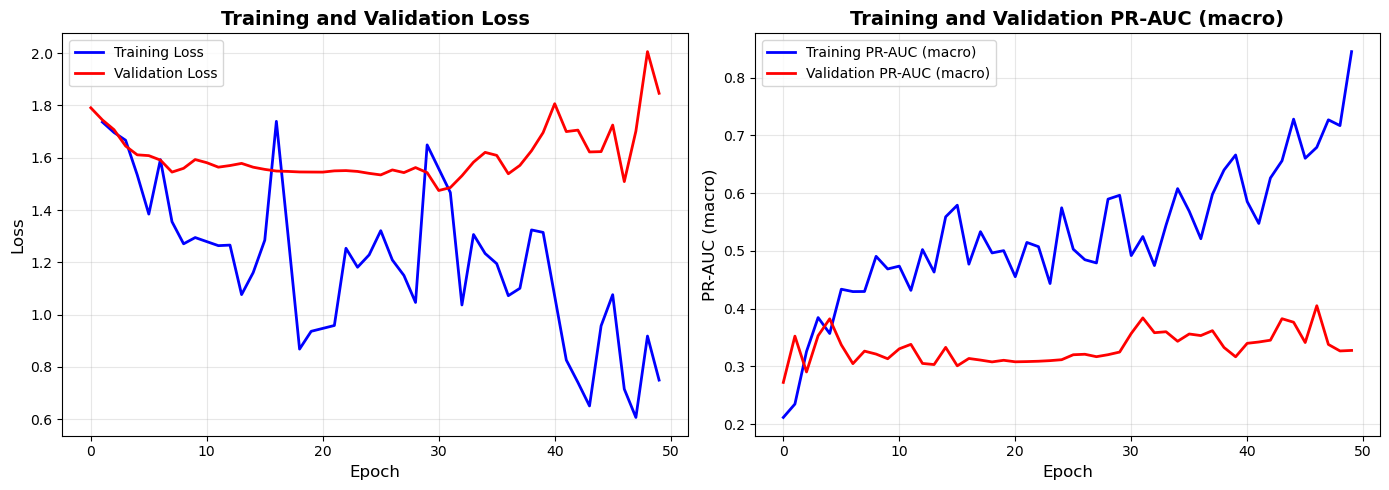

In [10]:
import matplotlib.pyplot as plt

# Plot training history from PyTorch Lightning logs
metrics_df = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot loss curves
train_loss = metrics_df.dropna(subset=['train_loss'])
val_loss = metrics_df.dropna(subset=['val_loss'])

ax1.plot(train_loss['epoch'], train_loss['train_loss'], 'b-', label='Training Loss', linewidth=2)
ax1.plot(val_loss['epoch'], val_loss['val_loss'], 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot metric curves
metric_name = METRIC_CONFIG[PRIMARY_METRIC]['monitor']
train_metric_name = metric_name.replace('val_', 'train_')
train_metric = metrics_df.dropna(subset=[train_metric_name])
val_metric = metrics_df.dropna(subset=[metric_name])

ax2.plot(train_metric['epoch'], train_metric[train_metric_name], 'b-', 
         label=f'Training {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', linewidth=2)
ax2.plot(val_metric['epoch'], val_metric[metric_name], 'r-', 
         label=f'Validation {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel(METRIC_CONFIG[PRIMARY_METRIC]['name'], fontsize=12)
ax2.set_title(f'Training and Validation {METRIC_CONFIG[PRIMARY_METRIC]["name"]}', 
              fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [11]:
# Load best model and evaluate
logger.info("\n" + "="*80)
logger.info("MODEL EVALUATION - Loading Best Model")
logger.info("="*80)

best_model = FlagPatternClassifier.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    input_dim=X.shape[2],
    num_classes=num_classes,
    class_weights=class_weights,
    weights_only=False  # Allow loading numpy arrays from checkpoint
)
best_model.eval()
best_model.freeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
best_model = best_model.to(device)

logger.info(f"Best model loaded from: {checkpoint_callback.best_model_path}")
logger.info(f"Device: {device}")

def get_predictions(loader, model):
    all_preds = []
    all_probs = []
    all_targets = []
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            logits = model(xb)
            probs = F.softmax(logits, dim=1).cpu().numpy()
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
            all_preds.append(preds)
            all_targets.append(yb.numpy())
    
    return np.concatenate(all_preds), np.concatenate(all_targets), np.concatenate(all_probs)

train_preds, train_targets, train_probs = get_predictions(train_loader, best_model)
val_preds, val_targets, val_probs = get_predictions(val_loader, best_model)

# Calculate metrics
train_acc = accuracy_score(train_targets, train_preds)
train_f1 = f1_score(train_targets, train_preds, average='macro')
train_auc_ovo = roc_auc_score(train_targets, train_probs, multi_class='ovo', average='macro')
train_auc_ovr = roc_auc_score(train_targets, train_probs, multi_class='ovr', average='macro')

val_acc = accuracy_score(val_targets, val_preds)
val_f1 = f1_score(val_targets, val_preds, average='macro')
val_auc_ovo = roc_auc_score(val_targets, val_probs, multi_class='ovo', average='macro')
val_auc_ovr = roc_auc_score(val_targets, val_probs, multi_class='ovr', average='macro')

train_targets_bin = label_binarize(train_targets, classes=range(num_classes))
val_targets_bin = label_binarize(val_targets, classes=range(num_classes))

train_pr_auc_per_class = [average_precision_score(train_targets_bin[:, i], train_probs[:, i]) for i in range(num_classes)]
val_pr_auc_per_class = [average_precision_score(val_targets_bin[:, i], val_probs[:, i]) for i in range(num_classes)]

train_pr_auc = np.mean(train_pr_auc_per_class)
val_pr_auc = np.mean(val_pr_auc_per_class)

logger.info("\n" + "="*80)
logger.info("VALIDATION RESULTS (Best Model)")
logger.info("="*80)
logger.info(f"Training Set:")
logger.info(f"  Accuracy:         {train_acc:.4f}")
logger.info(f"  F1 Score (macro): {train_f1:.4f}")
logger.info(f"  PR-AUC (macro):   {train_pr_auc:.4f}")
logger.info(f"  AUC-ROC (OvO):    {train_auc_ovo:.4f}")
logger.info(f"  AUC-ROC (OvR):    {train_auc_ovr:.4f}")
logger.info(f"\nValidation Set:")
logger.info(f"  Accuracy:         {val_acc:.4f}")
logger.info(f"  F1 Score (macro): {val_f1:.4f}")
logger.info(f"  PR-AUC (macro):   {val_pr_auc:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'pr_auc' else ''}")
logger.info(f"  AUC-ROC (OvO):    {val_auc_ovo:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'auc_ovo' else ''}")
logger.info(f"  AUC-ROC (OvR):    {val_auc_ovr:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'auc_ovr' else ''}")

2025-12-10 20:41:50,294 - INFO - 
2025-12-10 20:41:50,299 - INFO - MODEL EVALUATION - Loading Best Model
2025-12-10 20:41:50,300 - INFO - ================================================================================
2025-12-10 20:41:50,299 - INFO - MODEL EVALUATION - Loading Best Model
2025-12-10 20:41:50,300 - INFO - ================================================================================
2025-12-10 20:41:50,414 - INFO - Best model loaded from: /work/data/export/checkpoints_v2/best_model_pr_epoch=46_val_pr_auc=0.4051-v3.ckpt
2025-12-10 20:41:50,415 - INFO - Device: cuda
2025-12-10 20:41:50,414 - INFO - Best model loaded from: /work/data/export/checkpoints_v2/best_model_pr_epoch=46_val_pr_auc=0.4051-v3.ckpt
2025-12-10 20:41:50,415 - INFO - Device: cuda
2025-12-10 20:41:50,472 - INFO - 
2025-12-10 20:41:50,473 - INFO - VALIDATION RESULTS (Best Model)
2025-12-10 20:41:50,474 - INFO - ================================================================================
2025-12-10 20

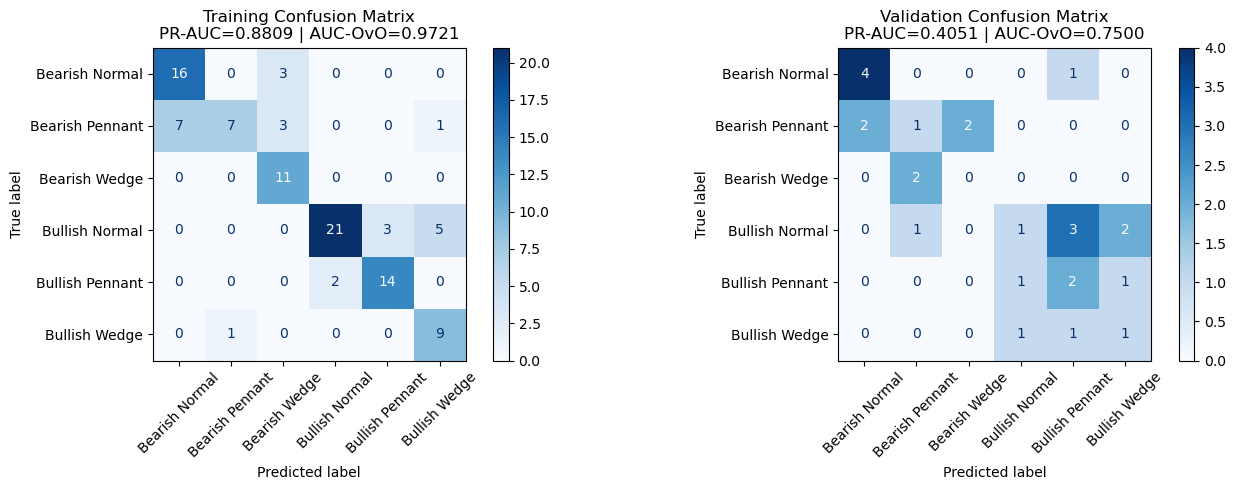


Classification report (validation):
                 precision    recall  f1-score   support

 Bearish Normal       0.67      0.80      0.73         5
Bearish Pennant       0.25      0.20      0.22         5
  Bearish Wedge       0.00      0.00      0.00         2
 Bullish Normal       0.33      0.14      0.20         7
Bullish Pennant       0.29      0.50      0.36         4
  Bullish Wedge       0.25      0.33      0.29         3

       accuracy                           0.35        26
      macro avg       0.30      0.33      0.30        26
   weighted avg       0.34      0.35      0.33        26



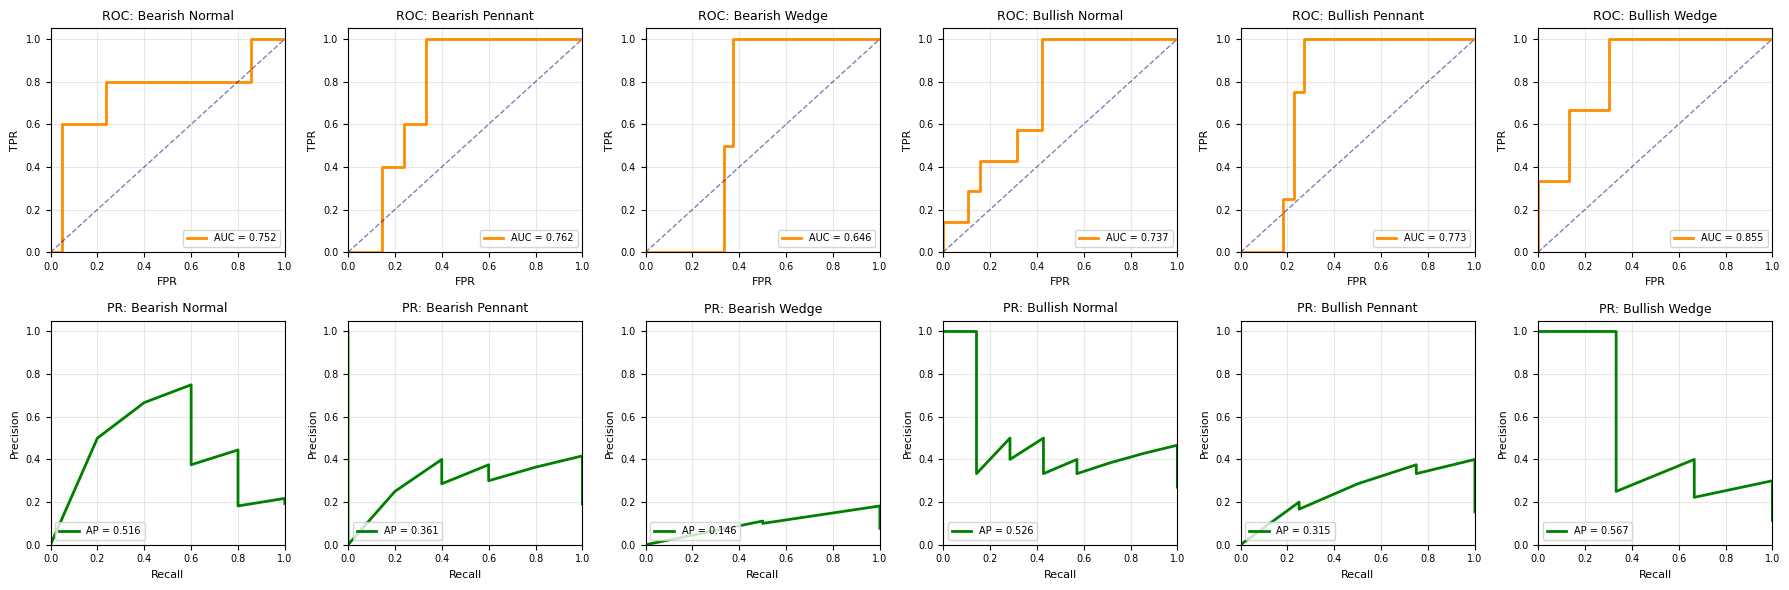

In [12]:
# Visualization - Confusion matrices and curves
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

cm_train = confusion_matrix(train_targets, train_preds)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=label_values)
disp_train.plot(ax=axes[0], cmap='Blues', xticks_rotation=45)
axes[0].set_title(f"Training Confusion Matrix\nPR-AUC={train_pr_auc:.4f} | AUC-OvO={train_auc_ovo:.4f}")

cm_val = confusion_matrix(val_targets, val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_values)
disp_val.plot(ax=axes[1], cmap='Blues', xticks_rotation=45)
axes[1].set_title(f"Validation Confusion Matrix\nPR-AUC={val_pr_auc:.4f} | AUC-OvO={val_auc_ovo:.4f}")

plt.tight_layout()
plt.show()

print("\nClassification report (validation):")
print(classification_report(val_targets, val_preds, target_names=[str(lbl) for lbl in label_values]))

# Plot ROC and PR curves
fig, axes = plt.subplots(2, 6, figsize=(18, 6))

for i in range(num_classes):
    # ROC curve
    fpr, tpr, _ = roc_curve(val_targets_bin[:, i], val_probs[:, i])
    roc_auc_class = auc(fpr, tpr)
    
    axes[0, i].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc_class:.3f}')
    axes[0, i].plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--', alpha=0.5)
    axes[0, i].set_xlim([0.0, 1.0])
    axes[0, i].set_ylim([0.0, 1.05])
    axes[0, i].set_xlabel('FPR', fontsize=8)
    axes[0, i].set_ylabel('TPR', fontsize=8)
    axes[0, i].set_title(f'ROC: {label_values[i]}', fontsize=9)
    axes[0, i].legend(loc="lower right", fontsize=7)
    axes[0, i].grid(alpha=0.3)
    axes[0, i].tick_params(labelsize=7)
    
    # PR curve
    precision, recall, _ = precision_recall_curve(val_targets_bin[:, i], val_probs[:, i])
    pr_auc_class = val_pr_auc_per_class[i]
    
    axes[1, i].plot(recall, precision, color='green', lw=2, label=f'AP = {pr_auc_class:.3f}')
    axes[1, i].set_xlim([0.0, 1.0])
    axes[1, i].set_ylim([0.0, 1.05])
    axes[1, i].set_xlabel('Recall', fontsize=8)
    axes[1, i].set_ylabel('Precision', fontsize=8)
    axes[1, i].set_title(f'PR: {label_values[i]}', fontsize=9)
    axes[1, i].legend(loc="lower left", fontsize=7)
    axes[1, i].grid(alpha=0.3)
    axes[1, i].tick_params(labelsize=7)

plt.tight_layout()
plt.show()

In [13]:
# Reload the baseline_model module to pick up any changes
import importlib
import sys

# Remove cached module if it exists
if 'baseline_model' in sys.modules:
    del sys.modules['baseline_model']

# Re-import
import baseline_model
print("Baseline model reloaded with current slope_threshold:", baseline_model.BaselineModel().slope_threshold)

Baseline model reloaded with current slope_threshold: 0.0002


Using segments CSV for baseline: /work/data/export/segments_values.csv
Baseline results shape: (144, 4)
Using slope_threshold: 0.0002
Number of evaluated segments: 144
Baseline accuracy: 0.3542
Baseline F1 score (macro): 0.3129
Baseline classes: ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']

Classification report (baseline):
                 precision    recall  f1-score   support

 Bearish Normal       0.38      0.33      0.35        27
Bearish Pennant       0.29      0.15      0.20        26
  Bearish Wedge       0.24      0.50      0.33        14
 Bullish Normal       0.55      0.57      0.56        40
Bullish Pennant       0.38      0.14      0.20        22
  Bullish Wedge       0.19      0.33      0.24        15

       accuracy                           0.35       144
      macro avg       0.33      0.34      0.31       144
   weighted avg       0.37      0.35      0.35       144



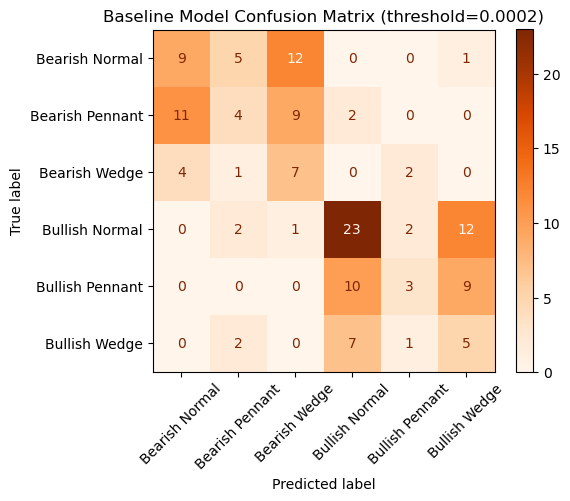

In [14]:
# Evaluate baseline model on the combined segments CSV and plot confusion matrix
import os
from baseline_model import predict_from_segments_csv, evaluate_on_segments_csv

# Path to the combined segment CSV produced by 01-data-exploration.ipynb
segments_csv_path = os.path.abspath("../data/export/segments_values.csv")
print("Using segments CSV for baseline:", segments_csv_path)

# Custom slope threshold for baseline model
BASELINE_SLOPE_THRESHOLD = 0.0002

# Run baseline model on all segments; this returns a DataFrame
baseline_results = predict_from_segments_csv(segments_csv_path, slope_threshold=BASELINE_SLOPE_THRESHOLD)
print("Baseline results shape:", baseline_results.shape)
print(f"Using slope_threshold: {BASELINE_SLOPE_THRESHOLD}")

# Keep only rows with ground-truth labels
mask = baseline_results["gold_label"].notna()
baseline_labels = baseline_results.loc[mask, "gold_label"].values
baseline_preds = baseline_results.loc[mask, "predicted_label"].values

print("Number of evaluated segments:", baseline_labels.shape[0])

# Print accuracy, F1 score, and classification report
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
baseline_acc = accuracy_score(baseline_labels, baseline_preds)
baseline_f1 = f1_score(baseline_labels, baseline_preds, average='macro')
print(f"Baseline accuracy: {baseline_acc:.4f}")
print(f"Baseline F1 score (macro): {baseline_f1:.4f}")

# Use label set from the baseline outputs
import numpy as np
baseline_label_values = np.sort(pd.unique(baseline_labels))
print("Baseline classes:", baseline_label_values)

print("\nClassification report (baseline):")
print(classification_report(baseline_labels, baseline_preds,
                            labels=baseline_label_values,
                            target_names=[str(lbl) for lbl in baseline_label_values]))

# Plot confusion matrix for baseline model
import matplotlib.pyplot as plt
cm_baseline = confusion_matrix(baseline_labels, baseline_preds, labels=baseline_label_values)
disp_baseline = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, display_labels=baseline_label_values)
fig, ax = plt.subplots(figsize=(6, 5))
disp_baseline.plot(ax=ax, cmap="Oranges", xticks_rotation=45)
ax.set_title(f"Baseline Model Confusion Matrix (threshold={BASELINE_SLOPE_THRESHOLD})")
plt.tight_layout()
plt.show()

Confusion matrix classes (ordered): ['Bearish Normal' 'Bearish Pennant' 'Bearish Wedge' 'Bullish Normal'
 'Bullish Pennant' 'Bullish Wedge']


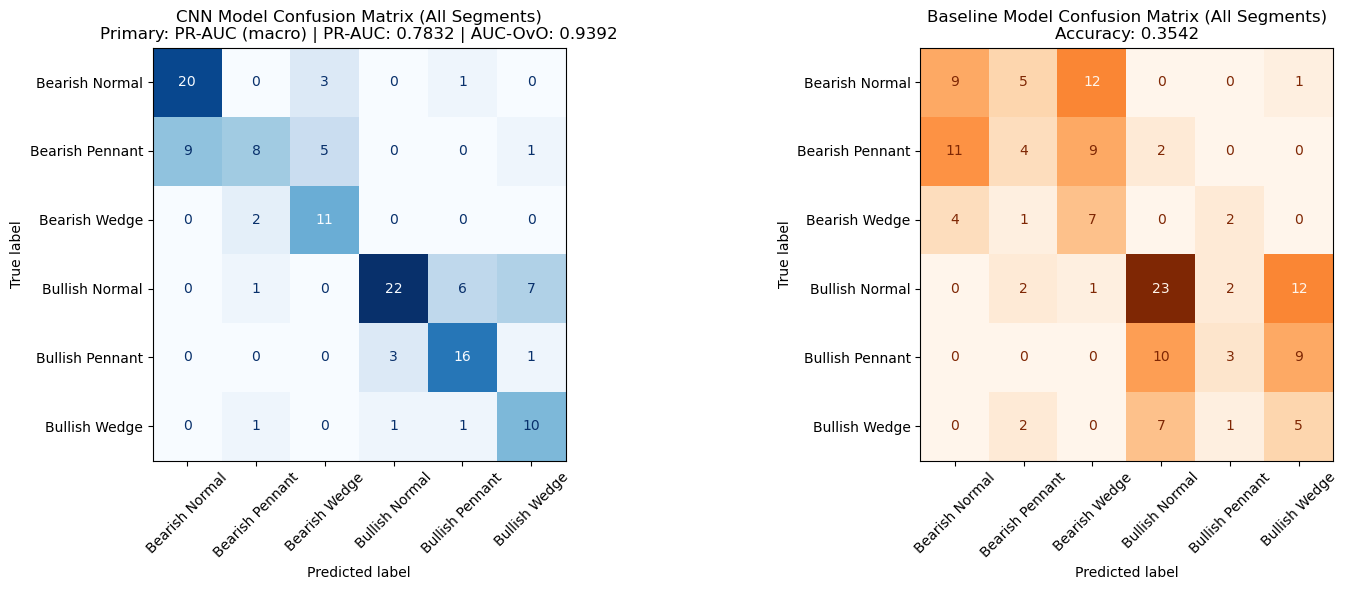


MODEL COMPARISON SUMMARY
CNN Model (selected by PR-AUC (macro)):
  Accuracy:         0.6744
  F1 Score (macro): 0.6602
  PR-AUC (macro):   0.7832  ← precision-recall curve
  AUC-ROC (OvO):    0.9392  ← pairwise discrimination (15 comparisons)
  AUC-ROC (OvR):    0.9368  ← each-vs-rest (6 comparisons)

Baseline Model (heuristic):
  Accuracy:         0.3542
  F1 Score (macro): 0.3129

PR-AUC is particularly useful for imbalanced datasets
It focuses on positive class performance and precision-recall trade-offs


In [15]:
# Compare confusion matrices of CNN model vs baseline on all segments
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, average_precision_score

# 1) CNN model predictions on all segments used for training
full_ds = SegmentDataset(X, y_idx)
full_loader = DataLoader(full_ds, batch_size=batch_size, shuffle=False)

cnn_preds_all, cnn_targets_all, cnn_probs_all = get_predictions(full_loader, best_model)

# Map integer indices back to label strings
cnn_true_labels = np.vectorize(idx_to_label.get)(cnn_targets_all)
cnn_pred_labels = np.vectorize(idx_to_label.get)(cnn_preds_all)

# Calculate all CNN metrics
cnn_acc = accuracy_score(cnn_true_labels, cnn_pred_labels)
cnn_f1 = f1_score(cnn_true_labels, cnn_pred_labels, average='macro')
cnn_auc_ovo = roc_auc_score(cnn_targets_all, cnn_probs_all, multi_class='ovo', average='macro')
cnn_auc_ovr = roc_auc_score(cnn_targets_all, cnn_probs_all, multi_class='ovr', average='macro')

# Calculate PR-AUC for CNN
cnn_targets_bin = label_binarize(cnn_targets_all, classes=range(num_classes))
cnn_pr_auc_per_class = [average_precision_score(cnn_targets_bin[:, i], cnn_probs_all[:, i]) for i in range(num_classes)]
cnn_pr_auc = np.mean(cnn_pr_auc_per_class)

# 2) Baseline predictions (already computed from segments_values.csv)
#    Using baseline_labels and baseline_preds from the previous cell

# Use the global label set from the CNN pipeline for consistent ordering
all_labels = label_values
print("Confusion matrix classes (ordered):", all_labels)

cm_cnn_all = confusion_matrix(cnn_true_labels, cnn_pred_labels, labels=all_labels)
cm_baseline_all = confusion_matrix(baseline_labels, baseline_preds, labels=all_labels)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN confusion matrix
cnn_disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_all, display_labels=all_labels)
cnn_disp.plot(ax=axes[0], cmap="Blues", xticks_rotation=45, colorbar=False)
axes[0].set_title(f"CNN Model Confusion Matrix (All Segments)\n"
                  f"Primary: {METRIC_CONFIG[PRIMARY_METRIC]['name']} | "
                  f"PR-AUC: {cnn_pr_auc:.4f} | AUC-OvO: {cnn_auc_ovo:.4f}")

# Baseline confusion matrix
base_disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_all, display_labels=all_labels)
base_disp.plot(ax=axes[1], cmap="Oranges", xticks_rotation=45, colorbar=False)
axes[1].set_title(f"Baseline Model Confusion Matrix (All Segments)\nAccuracy: {baseline_acc:.4f}")

plt.tight_layout()
plt.show()

# Print comparison summary
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)
print(f"CNN Model (selected by {METRIC_CONFIG[PRIMARY_METRIC]['name']}):")
print(f"  Accuracy:         {cnn_acc:.4f}")
print(f"  F1 Score (macro): {cnn_f1:.4f}")
print(f"  PR-AUC (macro):   {cnn_pr_auc:.4f}  ← precision-recall curve")
print(f"  AUC-ROC (OvO):    {cnn_auc_ovo:.4f}  ← pairwise discrimination (15 comparisons)")
print(f"  AUC-ROC (OvR):    {cnn_auc_ovr:.4f}  ← each-vs-rest (6 comparisons)")
print(f"\nBaseline Model (heuristic):")
print(f"  Accuracy:         {baseline_acc:.4f}")
print(f"  F1 Score (macro): {baseline_f1:.4f}")
print("="*70)
print(f"\nPR-AUC is particularly useful for imbalanced datasets")
print(f"It focuses on positive class performance and precision-recall trade-offs")

2025-12-10 20:41:51,629 - INFO - 
2025-12-10 20:41:51,630 - INFO - TEST SET EVALUATION - CNN Model
2025-12-10 20:41:51,630 - INFO - TEST SET EVALUATION - CNN Model
2025-12-10 20:41:51,631 - INFO - ================================================================================
2025-12-10 20:41:51,632 - INFO - Loading test data from:
2025-12-10 20:41:51,633 - INFO -   Preprocessed: /work/data/export/segments_preproc_24_test.csv
2025-12-10 20:41:51,633 - INFO -   Raw (for baseline): /work/data/export/segments_test_raw.csv
2025-12-10 20:41:51,643 - INFO - Test set loaded: 15 segments
2025-12-10 20:41:51,631 - INFO - ================================================================================
2025-12-10 20:41:51,632 - INFO - Loading test data from:
2025-12-10 20:41:51,633 - INFO -   Preprocessed: /work/data/export/segments_preproc_24_test.csv
2025-12-10 20:41:51,633 - INFO -   Raw (for baseline): /work/data/export/segments_test_raw.csv
2025-12-10 20:41:51,643 - INFO - Test set loaded: 

/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/conda/envs/workenv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0]

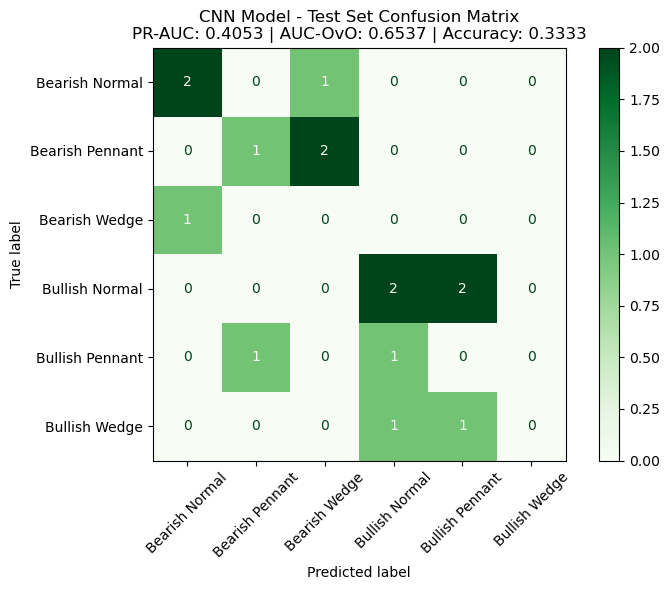

In [16]:
# Evaluate on held-out test set
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, 
    ConfusionMatrixDisplay, f1_score, roc_auc_score, 
    average_precision_score
)
from sklearn.preprocessing import label_binarize

logger.info("\n" + "="*80)
logger.info("TEST SET EVALUATION - CNN Model")
logger.info("="*80)

# Load test data
TEST_PREPROC_CSV = os.path.join(EXPORT_DIR, "segments_preproc_24_test.csv")
TEST_RAW_CSV = os.path.join(EXPORT_DIR, "segments_test_raw.csv")

logger.info(f"Loading test data from:")
logger.info(f"  Preprocessed: {TEST_PREPROC_CSV}")
logger.info(f"  Raw (for baseline): {TEST_RAW_CSV}")

df_test = pd.read_csv(TEST_PREPROC_CSV)
df_test = df_test.sort_values(["segment_id", "seq_pos"], kind="mergesort").reset_index(drop=True)

# Build test sequences (same as training pipeline)
test_segments = []
test_labels = []

for seg_id, g in df_test.groupby("segment_id", sort=True):
    g = g.sort_values("seq_pos", kind="mergesort")
    feat = g[feature_cols].to_numpy(dtype=np.float32)
    
    # Pad or truncate to 24 steps
    if feat.shape[0] < 24:
        pad = np.repeat(feat[-1:, :], 24 - feat.shape[0], axis=0)
        feat = np.concatenate([feat, pad], axis=0)
    elif feat.shape[0] > 24:
        feat = feat[:24, :]
    
    assert feat.shape[0] == 24, feat.shape
    test_segments.append(feat)
    test_labels.append(g["label"].iloc[0])

X_test = np.stack(test_segments, axis=0)
y_test_str = np.array(test_labels)
y_test = np.vectorize(label_to_idx.get)(y_test_str)

logger.info(f"Test set loaded: {X_test.shape[0]} segments")
logger.info("Test label distribution:")
test_label_dist = pd.Series(y_test_str).value_counts()
for label, count in test_label_dist.items():
    logger.info(f"  {label}: {count} samples ({count/len(y_test_str)*100:.1f}%)")

# Create test dataset and loader
test_ds = SegmentDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Get predictions on test set
test_preds, test_targets, test_probs = get_predictions(test_loader, best_model)

# Calculate all metrics for test set
test_acc = accuracy_score(test_targets, test_preds)
test_f1 = f1_score(test_targets, test_preds, average='macro')
test_auc_ovo = roc_auc_score(test_targets, test_probs, multi_class='ovo', average='macro')
test_auc_ovr = roc_auc_score(test_targets, test_probs, multi_class='ovr', average='macro')

# Calculate PR-AUC
test_targets_bin = label_binarize(test_targets, classes=range(num_classes))
test_pr_auc_per_class = [average_precision_score(test_targets_bin[:, i], test_probs[:, i]) for i in range(num_classes)]
test_pr_auc = np.mean(test_pr_auc_per_class)

# Map predictions back to labels
test_true_labels = np.vectorize(idx_to_label.get)(test_targets)
test_pred_labels = np.vectorize(idx_to_label.get)(test_preds)

logger.info("\n" + "="*80)
logger.info("FINAL EVALUATION - Test Set Results (CNN Model)")
logger.info("="*80)
logger.info(f"Accuracy:         {test_acc:.4f}")
logger.info(f"F1 Score (macro): {test_f1:.4f}")
logger.info(f"PR-AUC (macro):   {test_pr_auc:.4f} {'← PRIMARY METRIC' if PRIMARY_METRIC == 'pr_auc' else ''}")
logger.info(f"AUC-ROC (OvO):    {test_auc_ovo:.4f}")
logger.info(f"AUC-ROC (OvR):    {test_auc_ovr:.4f}")

# Log confusion matrix
cm_test = confusion_matrix(test_true_labels, test_pred_labels, labels=label_values)
logger.info("\nConfusion Matrix (Test Set):")
logger.info(f"Classes: {list(label_values)}")
for i, row in enumerate(cm_test):
    logger.info(f"  {label_values[i]}: {list(row)}")

# Log classification report
logger.info("\nDetailed Classification Report (Test Set):")
report = classification_report(test_true_labels, test_pred_labels, target_names=[str(lbl) for lbl in label_values])
for line in report.split('\n'):
    if line.strip():
        logger.info(f"  {line}")

# Plot test confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_values)
disp_test.plot(ax=ax, cmap="Greens", xticks_rotation=45, colorbar=True)
ax.set_title(f"CNN Model - Test Set Confusion Matrix\n"
             f"PR-AUC: {test_pr_auc:.4f} | AUC-OvO: {test_auc_ovo:.4f} | Accuracy: {test_acc:.4f}")
plt.tight_layout()
plt.show()


TEST SET EVALUATION - BASELINE MODEL
Baseline test results shape: (15, 4)
Number of evaluated test segments: 15
Accuracy:         0.2667
F1 Score (macro): 0.1889
Baseline test results shape: (15, 4)
Number of evaluated test segments: 15
Accuracy:         0.2667
F1 Score (macro): 0.1889


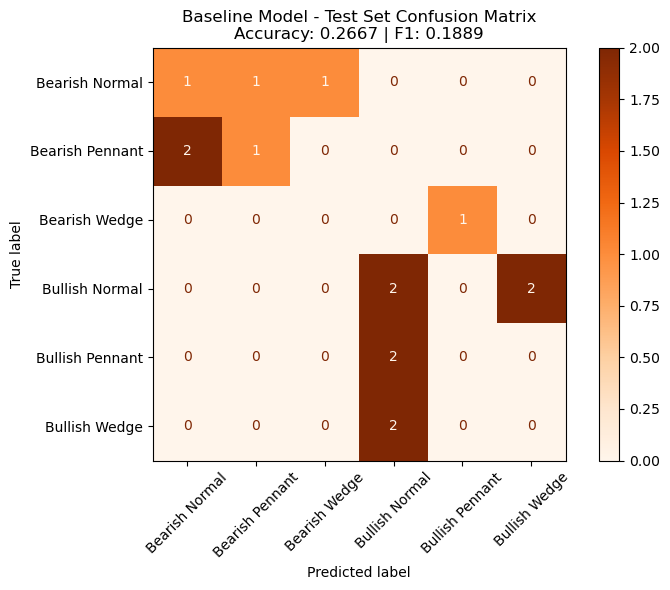


Classification Report (Baseline - Test Set):
                 precision    recall  f1-score   support

 Bearish Normal       0.33      0.33      0.33         3
Bearish Pennant       0.50      0.33      0.40         3
  Bearish Wedge       0.00      0.00      0.00         1
 Bullish Normal       0.33      0.50      0.40         4
Bullish Pennant       0.00      0.00      0.00         2
  Bullish Wedge       0.00      0.00      0.00         2

       accuracy                           0.27        15
      macro avg       0.19      0.19      0.19        15
   weighted avg       0.26      0.27      0.25        15



In [17]:
# Evaluate baseline model on test set
from baseline_model import predict_from_segments_csv

print("\n" + "="*70)
print("TEST SET EVALUATION - BASELINE MODEL")
print("="*70)

# Run baseline on test raw data
baseline_test_results = predict_from_segments_csv(TEST_RAW_CSV, slope_threshold=BASELINE_SLOPE_THRESHOLD)
print(f"Baseline test results shape: {baseline_test_results.shape}")

# Keep only rows with ground-truth labels
mask_test = baseline_test_results["gold_label"].notna()
baseline_test_labels = baseline_test_results.loc[mask_test, "gold_label"].values
baseline_test_preds = baseline_test_results.loc[mask_test, "predicted_label"].values

print(f"Number of evaluated test segments: {baseline_test_labels.shape[0]}")

# Calculate metrics
baseline_test_acc = accuracy_score(baseline_test_labels, baseline_test_preds)
baseline_test_f1 = f1_score(baseline_test_labels, baseline_test_preds, average='macro')

print(f"Accuracy:         {baseline_test_acc:.4f}")
print(f"F1 Score (macro): {baseline_test_f1:.4f}")
print("="*70)

# Plot baseline test confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cm_baseline_test = confusion_matrix(baseline_test_labels, baseline_test_preds, labels=label_values)
disp_baseline_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_test, display_labels=label_values)
disp_baseline_test.plot(ax=ax, cmap="Oranges", xticks_rotation=45, colorbar=True)
ax.set_title(f"Baseline Model - Test Set Confusion Matrix\n"
             f"Accuracy: {baseline_test_acc:.4f} | F1: {baseline_test_f1:.4f}")
plt.tight_layout()
plt.show()

print("\nClassification Report (Baseline - Test Set):")
print(classification_report(baseline_test_labels, baseline_test_preds, 
                            labels=label_values,
                            target_names=[str(lbl) for lbl in label_values]))

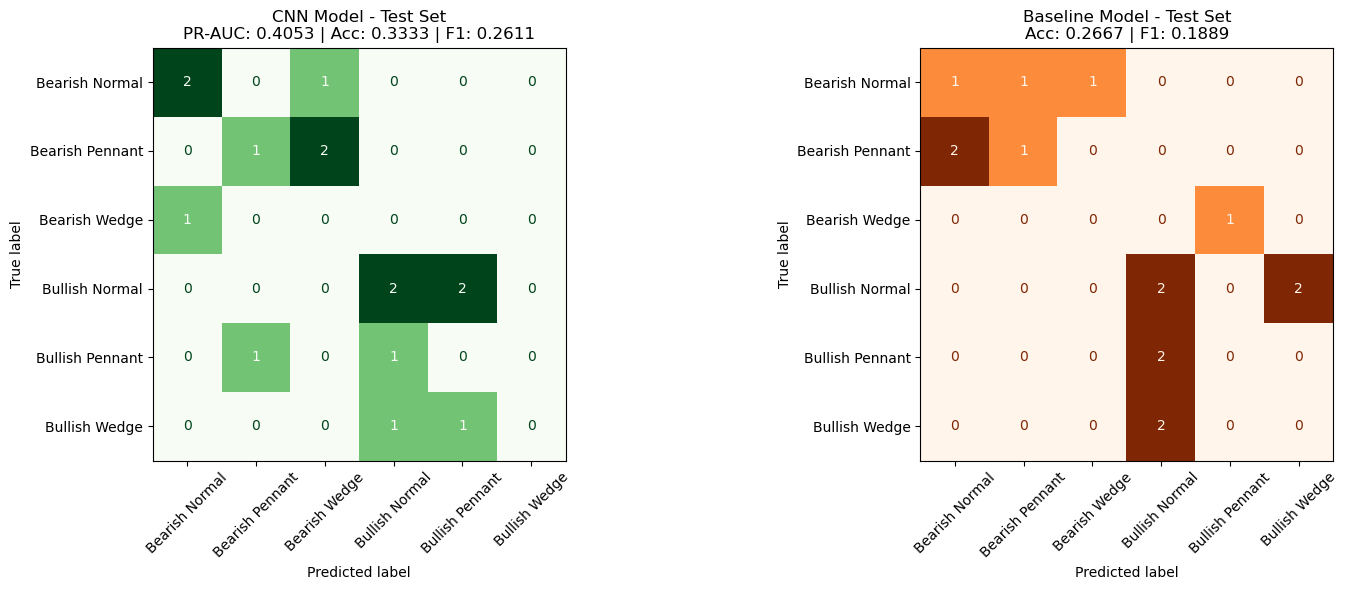

2025-12-10 20:41:52,068 - INFO - 
2025-12-10 20:41:52,069 - INFO - FINAL MODEL COMPARISON - Test Set Performance
2025-12-10 20:41:52,070 - INFO - ================================================================================
2025-12-10 20:41:52,070 - INFO - 
CNN Model (Deep Learning):
2025-12-10 20:41:52,071 - INFO -   Accuracy:         0.3333
2025-12-10 20:41:52,071 - INFO -   F1 Score (macro): 0.2611
2025-12-10 20:41:52,072 - INFO -   PR-AUC (macro):   0.4053
2025-12-10 20:41:52,073 - INFO -   AUC-ROC (OvO):    0.6537
2025-12-10 20:41:52,073 - INFO -   AUC-ROC (OvR):    0.6714
2025-12-10 20:41:52,074 - INFO - 
Baseline Model (Heuristic):
2025-12-10 20:41:52,074 - INFO -   Accuracy:         0.2667
2025-12-10 20:41:52,075 - INFO -   F1 Score (macro): 0.1889
2025-12-10 20:41:52,076 - INFO - 
Improvement (CNN vs Baseline):
2025-12-10 20:41:52,076 - INFO -   Accuracy:  +0.0667 (+25.0%)
2025-12-10 20:41:52,077 - INFO -   F1 Score:  +0.0722 (+38.2%)
2025-12-10 20:41:52,077 - INFO - 
2025-

In [18]:
# Side-by-side comparison: CNN vs Baseline on Test Set
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# CNN test confusion matrix
cnn_disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_values)
cnn_disp_test.plot(ax=axes[0], cmap="Greens", xticks_rotation=45, colorbar=False)
axes[0].set_title(f"CNN Model - Test Set\n"
                  f"PR-AUC: {test_pr_auc:.4f} | Acc: {test_acc:.4f} | F1: {test_f1:.4f}")

# Baseline test confusion matrix
base_disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_baseline_test, display_labels=label_values)
base_disp_test.plot(ax=axes[1], cmap="Oranges", xticks_rotation=45, colorbar=False)
axes[1].set_title(f"Baseline Model - Test Set\n"
                  f"Acc: {baseline_test_acc:.4f} | F1: {baseline_test_f1:.4f}")

plt.tight_layout()
plt.show()

# Print comprehensive comparison
logger.info("\n" + "="*80)
logger.info("FINAL MODEL COMPARISON - Test Set Performance")
logger.info("="*80)
logger.info(f"\nCNN Model (Deep Learning):")
logger.info(f"  Accuracy:         {test_acc:.4f}")
logger.info(f"  F1 Score (macro): {test_f1:.4f}")
logger.info(f"  PR-AUC (macro):   {test_pr_auc:.4f}")
logger.info(f"  AUC-ROC (OvO):    {test_auc_ovo:.4f}")
logger.info(f"  AUC-ROC (OvR):    {test_auc_ovr:.4f}")

logger.info(f"\nBaseline Model (Heuristic):")
logger.info(f"  Accuracy:         {baseline_test_acc:.4f}")
logger.info(f"  F1 Score (macro): {baseline_test_f1:.4f}")

acc_improvement = test_acc - baseline_test_acc
f1_improvement = test_f1 - baseline_test_f1
acc_pct = (test_acc / baseline_test_acc - 1) * 100 if baseline_test_acc > 0 else 0
f1_pct = (test_f1 / baseline_test_f1 - 1) * 100 if baseline_test_f1 > 0 else 0

logger.info(f"\nImprovement (CNN vs Baseline):")
logger.info(f"  Accuracy:  {acc_improvement:+.4f} ({acc_pct:+.1f}%)")
logger.info(f"  F1 Score:  {f1_improvement:+.4f} ({f1_pct:+.1f}%)")

logger.info("\n" + "="*80)
logger.info("EXPERIMENT COMPLETED SUCCESSFULLY")
logger.info(f"Completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
logger.info("="*80)